In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
import talib as tal
import ta
import hvplot.pandas
import matplotlib.pyplot as plt
from matplotlib import gridspec
import panel as pn


Bad key savefig.frameon in file C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\sator\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probab

In [2]:
#Select stocks
tickers = ['AAPL', 'F', 'BAC']

In [3]:
#Select period - pre-GFC and post-GFC
start = '2007, 1, 1'
end = '2015, 1, 1'

In [5]:
stocks = []
for ticker in tickers:
    stock = web.get_data_yahoo(ticker, start=start, end=end)['Adj Close'].reset_index()
    stock = stock.set_index('Date')
    stocks.append(stock)

In [6]:
#SMA
def sma(df):
    df['MA20'] = df['Adj Close'].rolling(20).mean()
    df['MA50'] = df['Adj Close'].rolling(50).mean()
    
    buy = []
    sell = []

    for i in range(len(df)):       
        if df.MA20.iloc[i] > df.MA50.iloc[i] and df.MA20.iloc[i-1] < df.MA50.iloc[i-1]:
            buy.append(i)
        elif df.MA20.iloc[i] < df.MA50.iloc[i] and df.MA20.iloc[i-1] > df.MA50.iloc[i-1]:
            sell.append(i)
    
    return buy, sell

In [7]:
#MACD
def macd(df):
    stock['MACD'], stock['MACD signal'], macdhist = tal.MACD(stock['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

    buy = []
    sell = []

    for i in range(len(stock)):
        if (stock['MACD'].iloc[i] > stock['MACD signal'].iloc[i]) & (stock['MACD'].iloc[i-1] < stock['MACD signal'].iloc[i-1]):
            buy.append(i)
        elif (stock['MACD'].iloc[i] < stock['MACD signal'].iloc[i]) & (stock['MACD'].iloc[i-1] > stock['MACD signal'].iloc[i-1]):
            sell.append(i)
    
    return buy, sell

In [8]:
#RSI
def rsi(df):
    df['SMA200'] = ta.trend.sma_indicator(df['Adj Close'], window=200)
    df['RSI'] = ta.momentum.rsi(df['Adj Close'], window=10)
    df['Signal'] = np.where((df['Adj Close'] > df['SMA200']) & (df.RSI < 30), True, False)

    buy = []
    sell = []

    for i in range(len(df)):
        if df.Signal.iloc[i]:
            buy.append(i + 1)
            for j in range (1,11):
                if df['RSI'].iloc[i + j] > 40:
                    sell.append(i + j + 1)
                    break
                
                elif j == 10:
                    sell.append(i + j + 1)
    return buy, sell

In [9]:
#Price move charts with buy/sell signals

#Apple

#SMA price chart
def apple_sma():
        buy, sell = sma(stocks[0])
        fig = plt.figure(figsize=(20, 10))
        plt.plot(stocks[0]['Adj Close'], label= 'Asset Price', c='blue', alpha=0.5)
        plt.plot(stocks[0]['MA20'], label='MA20', c='black', alpha=0.9)
        plt.plot(stocks[0]['MA50'], label='MA50', c='magenta', alpha=0.9)
        plt.scatter(stocks[0].iloc[buy].index,stocks[0].iloc[buy]['Adj Close'], marker='^', c='green', s=100)
        plt.scatter(stocks[0].iloc[sell].index,stocks[0].iloc[sell]['Adj Close'], marker='v', c='red', s=100)
        plt.legend()
        plt.title('Apple SMA Chart')
        plt.close()
        return fig
    
#MACD price chart       
def apple_macd():
        buy, sell = macd(stocks[0])
        fig = plt.figure(figsize=(20, 10))
        spec = gridspec.GridSpec(ncols=1, nrows=2,
                             height_ratios=[1.5, 1])
        ax0 = fig.add_subplot(spec[0])
        ax0.plot(stocks[0]['Adj Close'])
        ax0.legend(['Asset Price'])
        ax1 = fig.add_subplot(spec[1])
        ax1.plot(stocks[0][['MACD', 'MACD signal']])
        ax1.scatter(stocks[0].iloc[buy].index, stocks[0].iloc[buy]['MACD'], marker='^', c='green', s=100)
        ax1.scatter(stocks[0].iloc[sell].index, stocks[0].iloc[sell]['MACD'], marker='v', c='red', s=100)
        ax1.legend(['MACD', 'MACD signal'])
        ax0.set_title('Apple MACD Chart')
        plt.subplots_adjust(hspace=0)
        plt.close()
        return fig

#RSI price chart
def apple_rsi():
        buy, sell = rsi(stocks[0])
        fig = plt.figure(figsize=(20, 10))
        spec = gridspec.GridSpec(ncols=1, nrows=2,
                             height_ratios=[1.5, 1])
        ax0 = fig.add_subplot(spec[0])
        ax0.plot(stocks[0]['Adj Close'], c='blue', alpha=0.5)
        ax0.plot(stocks[0]['SMA200'], c='black', alpha=0.9)
        ax0.legend(['Asset price', 'SMA200'])
        ax0.scatter(stocks[0].iloc[buy].index, 
                stocks[0].iloc[buy]['Adj Close'], 
                marker='^', 
                c='b')

        ax0.scatter(stocks[0].iloc[sell].index, 
                stocks[0].iloc[sell]['Adj Close'], 
                marker='v', 
                c='r')
        ax1 = fig.add_subplot(spec[1])
        ax1.plot(stocks[0]['RSI'], label='RSI', c='magenta')
        ax1.legend(['RSI'])
        ax1.axhline(y=30, color='black')
        ax0.set_title('Apple RSI Chart')
        plt.subplots_adjust(hspace=0)
        plt.close()
        return fig

#Ford
    
#SMA price chart
def ford_sma():
        buy, sell = sma(stocks[1])
        fig = plt.figure(figsize=(20, 10))
        plt.plot(stocks[1]['Adj Close'], label= 'Asset Price', c='blue', alpha=0.5)
        plt.plot(stocks[1]['MA20'], label='MA20', c='black', alpha=0.9)
        plt.plot(stocks[1]['MA50'], label='MA50', c='magenta', alpha=0.9)
        plt.scatter(stocks[1].iloc[buy].index,stocks[1].iloc[buy]['Adj Close'], marker='^', c='green', s=100)
        plt.scatter(stocks[1].iloc[sell].index,stocks[1].iloc[sell]['Adj Close'], marker='v', c='red', s=100)
        plt.title('Ford SMA Chart')
        plt.legend()
        plt.close()
        return fig

#MACD price chart
def ford_macd():
        buy, sell = macd(stocks[1])
        fig = plt.figure(figsize=(20, 10))
        spec = gridspec.GridSpec(ncols=1, nrows=2,
                             height_ratios=[1.5, 1])
        ax0 = fig.add_subplot(spec[0])
        ax0.plot(stocks[1]['Adj Close'])
        ax0.legend(['Asset Price'])
        ax1 = fig.add_subplot(spec[1])
        ax1.plot(stocks[1][['MACD', 'MACD signal']])
        ax1.scatter(stocks[1].iloc[buy].index, stocks[1].iloc[buy]['MACD'], marker='^', c='green', s=100)
        ax1.scatter(stocks[1].iloc[sell].index, stocks[1].iloc[sell]['MACD'], marker='v', c='red', s=100)
        ax1.legend(['MACD', 'MACD signal'])
        ax0.set_title('Ford MACD Chart')
        plt.subplots_adjust(hspace=0)
        plt.close()
        return fig
    
#RSI price chart
def ford_rsi():
        buy, sell = rsi(stocks[1])
        fig = plt.figure(figsize=(20, 10))
        spec = gridspec.GridSpec(ncols=1, nrows=2,
                             height_ratios=[1.5, 1])
        ax0 = fig.add_subplot(spec[0])
        ax0.plot(stocks[1]['Adj Close'], c='blue', alpha=0.5)
        ax0.plot(stocks[1]['SMA200'], c='black', alpha=0.9)
        ax0.legend(['Asset price', 'SMA200'])
        ax0.scatter(stocks[1].iloc[buy].index, 
                stocks[1].iloc[buy]['Adj Close'], 
                marker='^', 
                c='b')

        ax0.scatter(stocks[1].iloc[sell].index, 
                stocks[1].iloc[sell]['Adj Close'], 
                marker='v', 
                c='r')
        ax1 = fig.add_subplot(spec[1])
        ax1.plot(stocks[1]['RSI'], label='RSI', c='magenta')
        ax1.legend(['RSI'])
        ax1.axhline(y=30, color='black')
        ax0.set_title('Ford RSI Chart')
        plt.subplots_adjust(hspace=0)
        plt.close()
        return fig

#Bank of America
    
#SMA price chart
def bac_sma():
        buy, sell = sma(stocks[2])
        fig = plt.figure(figsize=(20, 10))
        plt.plot(stocks[2]['Adj Close'], label= 'Asset Price', c='blue', alpha=0.5)
        plt.plot(stocks[2]['MA20'], label='MA20', c='black', alpha=0.9)
        plt.plot(stocks[2]['MA50'], label='MA50', c='magenta', alpha=0.9)
        plt.scatter(stocks[2].iloc[buy].index,stocks[2].iloc[buy]['Adj Close'], marker='^', c='green', s=100)
        plt.scatter(stocks[2].iloc[sell].index,stocks[2].iloc[sell]['Adj Close'], marker='v', c='red', s=100)
        plt.title('Bank of America SMA Chart')
        plt.legend()
        plt.close()
        return fig

#MACD price chart
def bac_macd():
        buy, sell = macd(stocks[2])
        fig = plt.figure(figsize=(20, 10))
        spec = gridspec.GridSpec(ncols=1, nrows=2,
                             height_ratios=[1.5, 1])
        ax0 = fig.add_subplot(spec[0])
        ax0.plot(stocks[2]['Adj Close'])
        ax0.legend(['Asset Price'])
        ax1 = fig.add_subplot(spec[1])
        ax1.plot(stocks[2][['MACD', 'MACD signal']])
        ax1.scatter(stocks[2].iloc[buy].index, stocks[2].iloc[buy]['MACD'], marker='^', c='green', s=100)
        ax1.scatter(stocks[2].iloc[sell].index, stocks[2].iloc[sell]['MACD'], marker='v', c='red', s=100)
        ax1.legend(['MACD', 'MACD signal'])
        ax0.set_title('Bank of America MACD Chart')
        plt.subplots_adjust(hspace=0)
        plt.close()
        return fig

#RSI price chart
def bac_rsi():
        buy, sell = rsi(stocks[2])
        fig = plt.figure(figsize=(20, 10))
        spec = gridspec.GridSpec(ncols=1, nrows=2,
                             height_ratios=[1.5, 1])
        ax0 = fig.add_subplot(spec[0])
        ax0.plot(stocks[2]['Adj Close'], c='blue', alpha=0.5)
        ax0.plot(stocks[2]['SMA200'], c='black', alpha=0.9)
        ax0.legend(['Asset price', 'SMA200'])
        ax0.scatter(stocks[2].iloc[buy].index, 
                stocks[2].iloc[buy]['Adj Close'], 
                marker='^', 
                c='b')

        ax0.scatter(stocks[2].iloc[sell].index, 
                stocks[2].iloc[sell]['Adj Close'], 
                marker='v', 
                c='r')
        ax1 = fig.add_subplot(spec[1])
        ax1.plot(stocks[2]['RSI'], label='RSI', c='magenta')
        ax1.legend(['RSI'])
        ax1.axhline(y=30, color='black')
        ax0.set_title('Bank of America RSI Chart')
        plt.subplots_adjust(hspace=0)
        plt.close()
        return fig

In [10]:
#Absonute returns & win rates

returns = []
wins = []

for stock in stocks:
    
    sma_buy, sma_sell = sma(stock)
    if len(sma_buy) > len(sma_sell):
        sma_buy = np.delete(sma_buy, 0)    
    elif len(sma_buy) < len(sma_sell):
        sma_sell = np.delete(sma_sell, 0)
    sma_ret = (stock.iloc[sma_sell]['Adj Close'].values - stock.iloc[sma_buy]['Adj Close'].values) / stock.iloc[sma_buy]['Adj Close'].values
    sma_cum_return = (pd.Series(sma_ret) + 1).cumprod().iloc[-1] - 1
    sma_wins = [i for i in sma_ret if i > 0]
    sma_win_rate = len(sma_wins) / len(sma_ret)
    
    macd_buy, macd_sell = macd(stock)
    if len(macd_buy) > len(macd_sell):
        macd_buy = np.delete(macd_buy, 0)    
    elif len(macd_buy) < len(macd_sell):
        macd_sell = np.delete(macd_sell, 0)
    macd_ret = (stock.iloc[macd_sell]['Adj Close'].values - stock.iloc[macd_buy]['Adj Close'].values) / stock.iloc[macd_buy]['Adj Close'].values
    macd_cum_return = (pd.Series(macd_ret) + 1).cumprod().iloc[-1] - 1
    macd_ret = (stock.iloc[macd_sell]['Adj Close'].values - stock.iloc[macd_buy]['Adj Close'].values) / stock.iloc[macd_buy]['Adj Close'].values
    macd_cum_return = (pd.Series(macd_ret) + 1).cumprod().iloc[-1] - 1
    macd_wins = [i for i in macd_ret if i > 0]
    macd_win_rate = len(macd_wins) / len(macd_ret)
    
    rsi_buy, rsi_sell = rsi(stock)
    rsi_ret = (stock.iloc[rsi_sell]['Adj Close'].values - stock.iloc[rsi_buy]['Adj Close'].values) / stock.iloc[rsi_buy]['Adj Close'].values
    rsi_cum_return = (pd.Series(rsi_ret) + 1).cumprod().iloc[-1] - 1
    rsi_wins = [i for i in rsi_ret if i > 0]
    rsi_win_rate = len(rsi_wins) / len(rsi_ret)
    
    buy_hold = (stock['Adj Close'].pct_change() + 1).cumprod().iloc[-1] - 1
    
    cum_rets = pd.DataFrame([sma_cum_return, macd_cum_return, rsi_cum_return, buy_hold], index=['SMA', 'MACD', 'RSI', 'Buy & Hold'])
    returns.append(cum_rets)
    
    win_rates = pd.DataFrame([sma_win_rate, macd_win_rate, rsi_win_rate], index=['SMA', 'MACD', 'RSI'])
    wins.append(win_rates)
    

Column
    [0] Row
        [0] Markdown(str, width=700)
    [1] Markdown(str)
    [2] Tabs
        [0] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [1] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [2] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [3] Column
            [0] HoloViews(Bars)
            [1] HoloViews(Bars)
            [2] HoloViews(Bars)
        [4] Column
            [0] HoloViews(Bars)
            [1] HoloViews(Bars)
            [2] HoloViews(Bars)
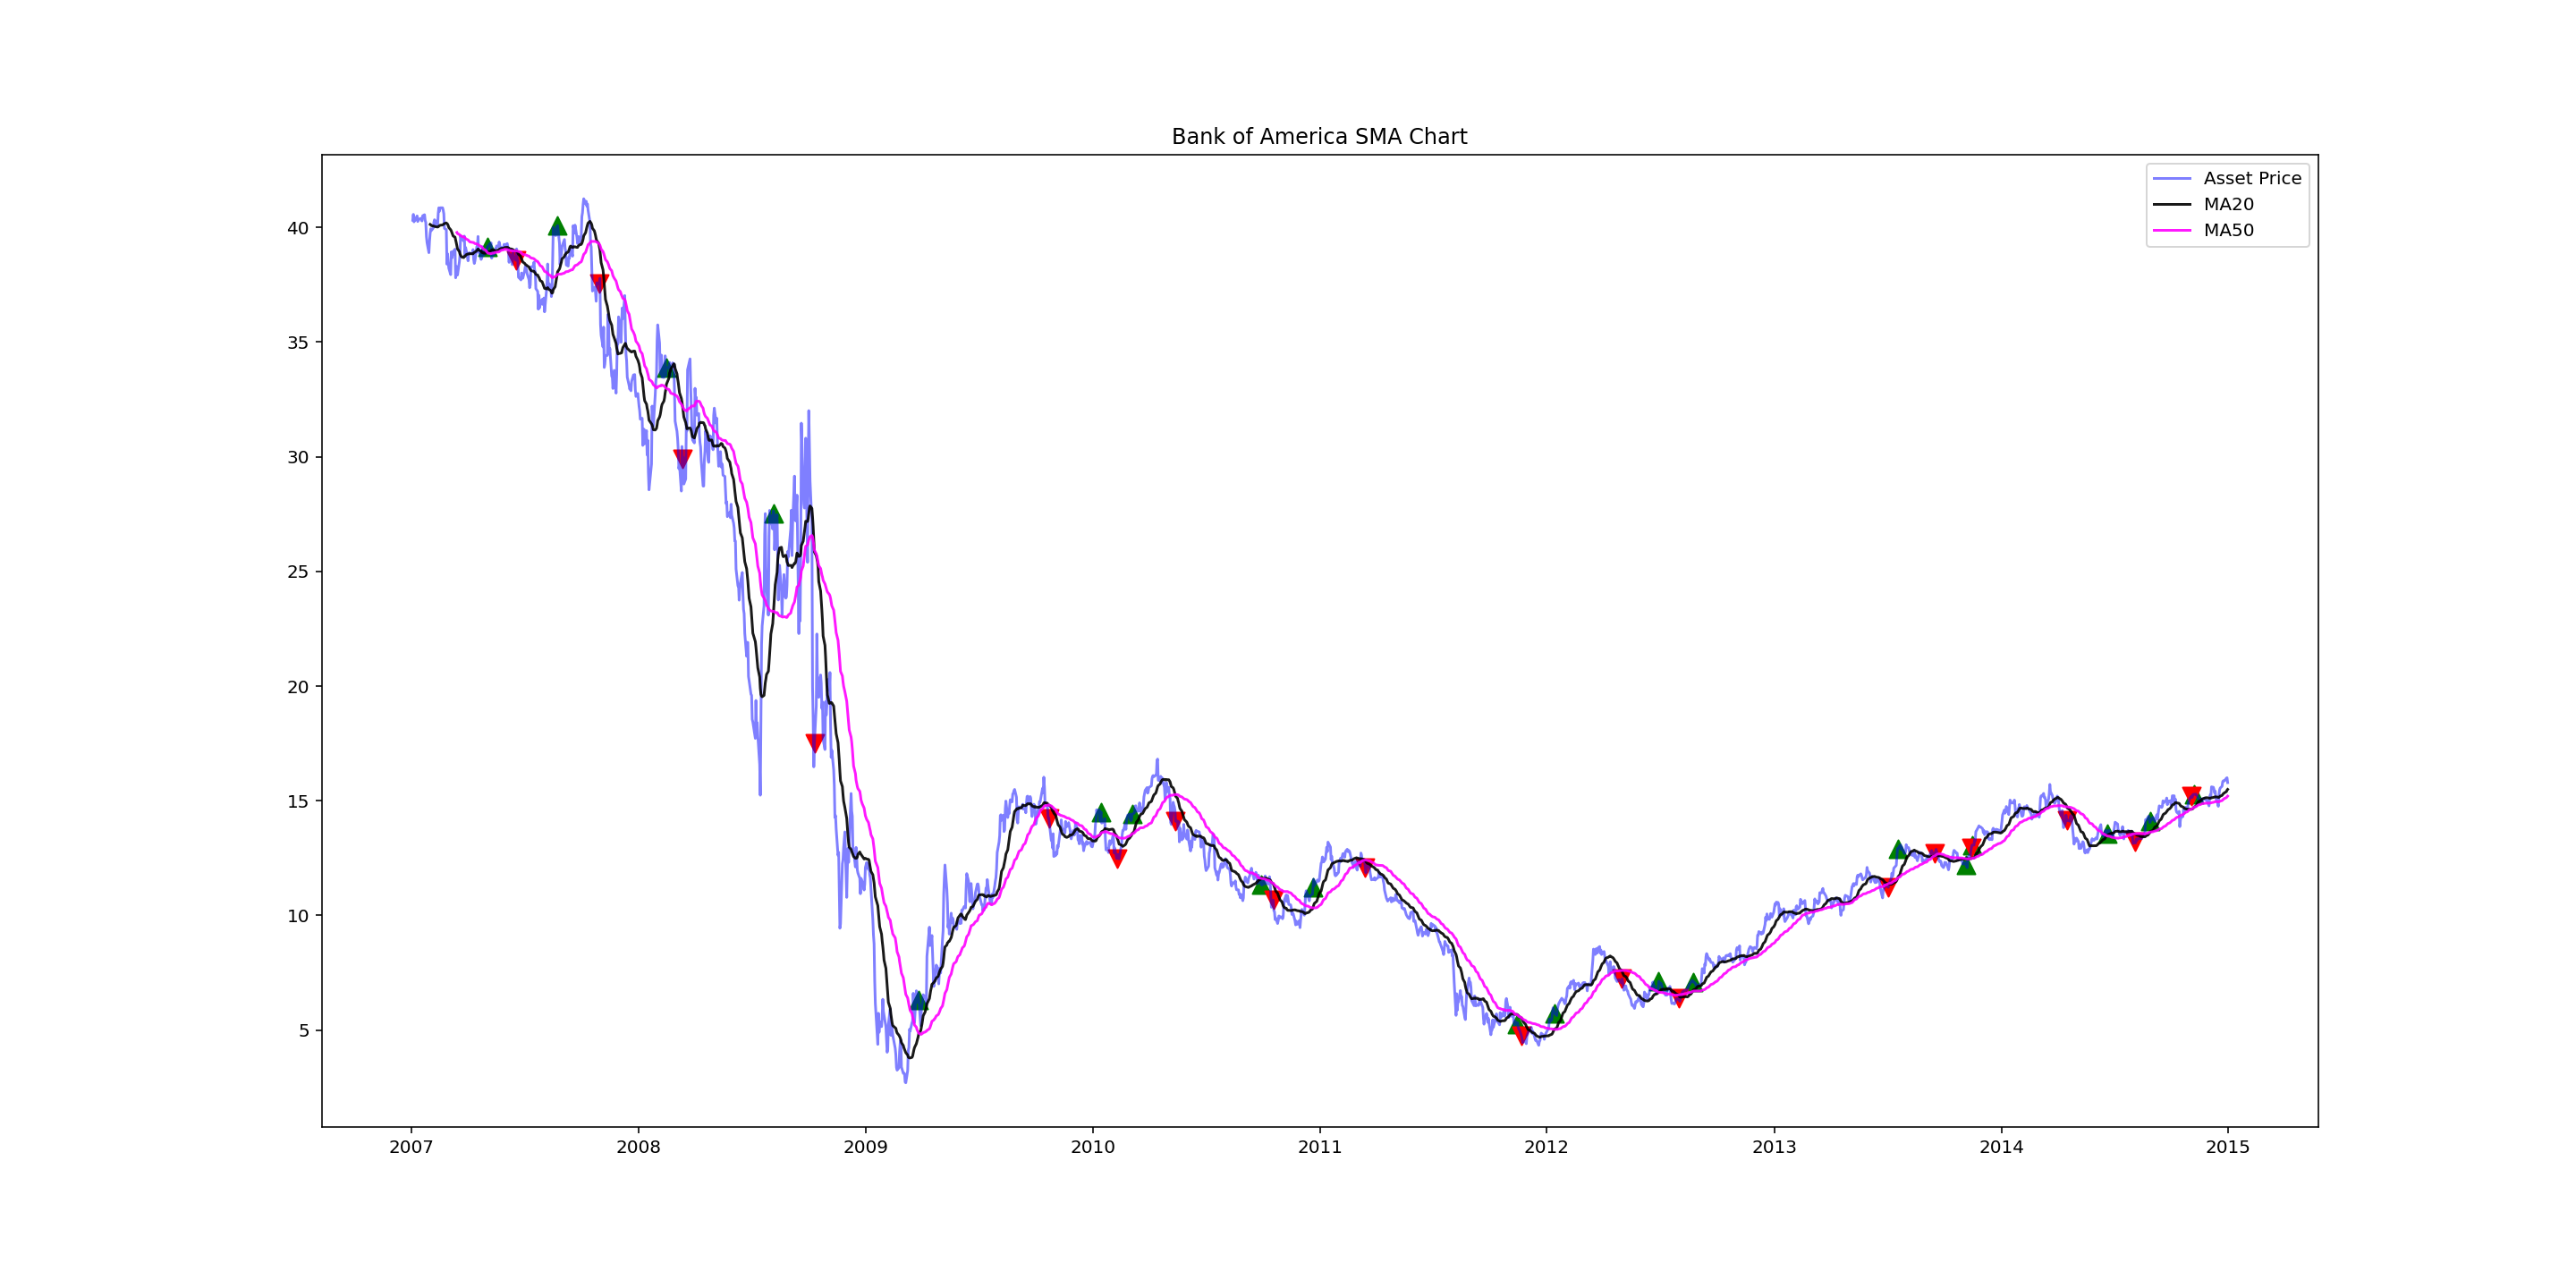
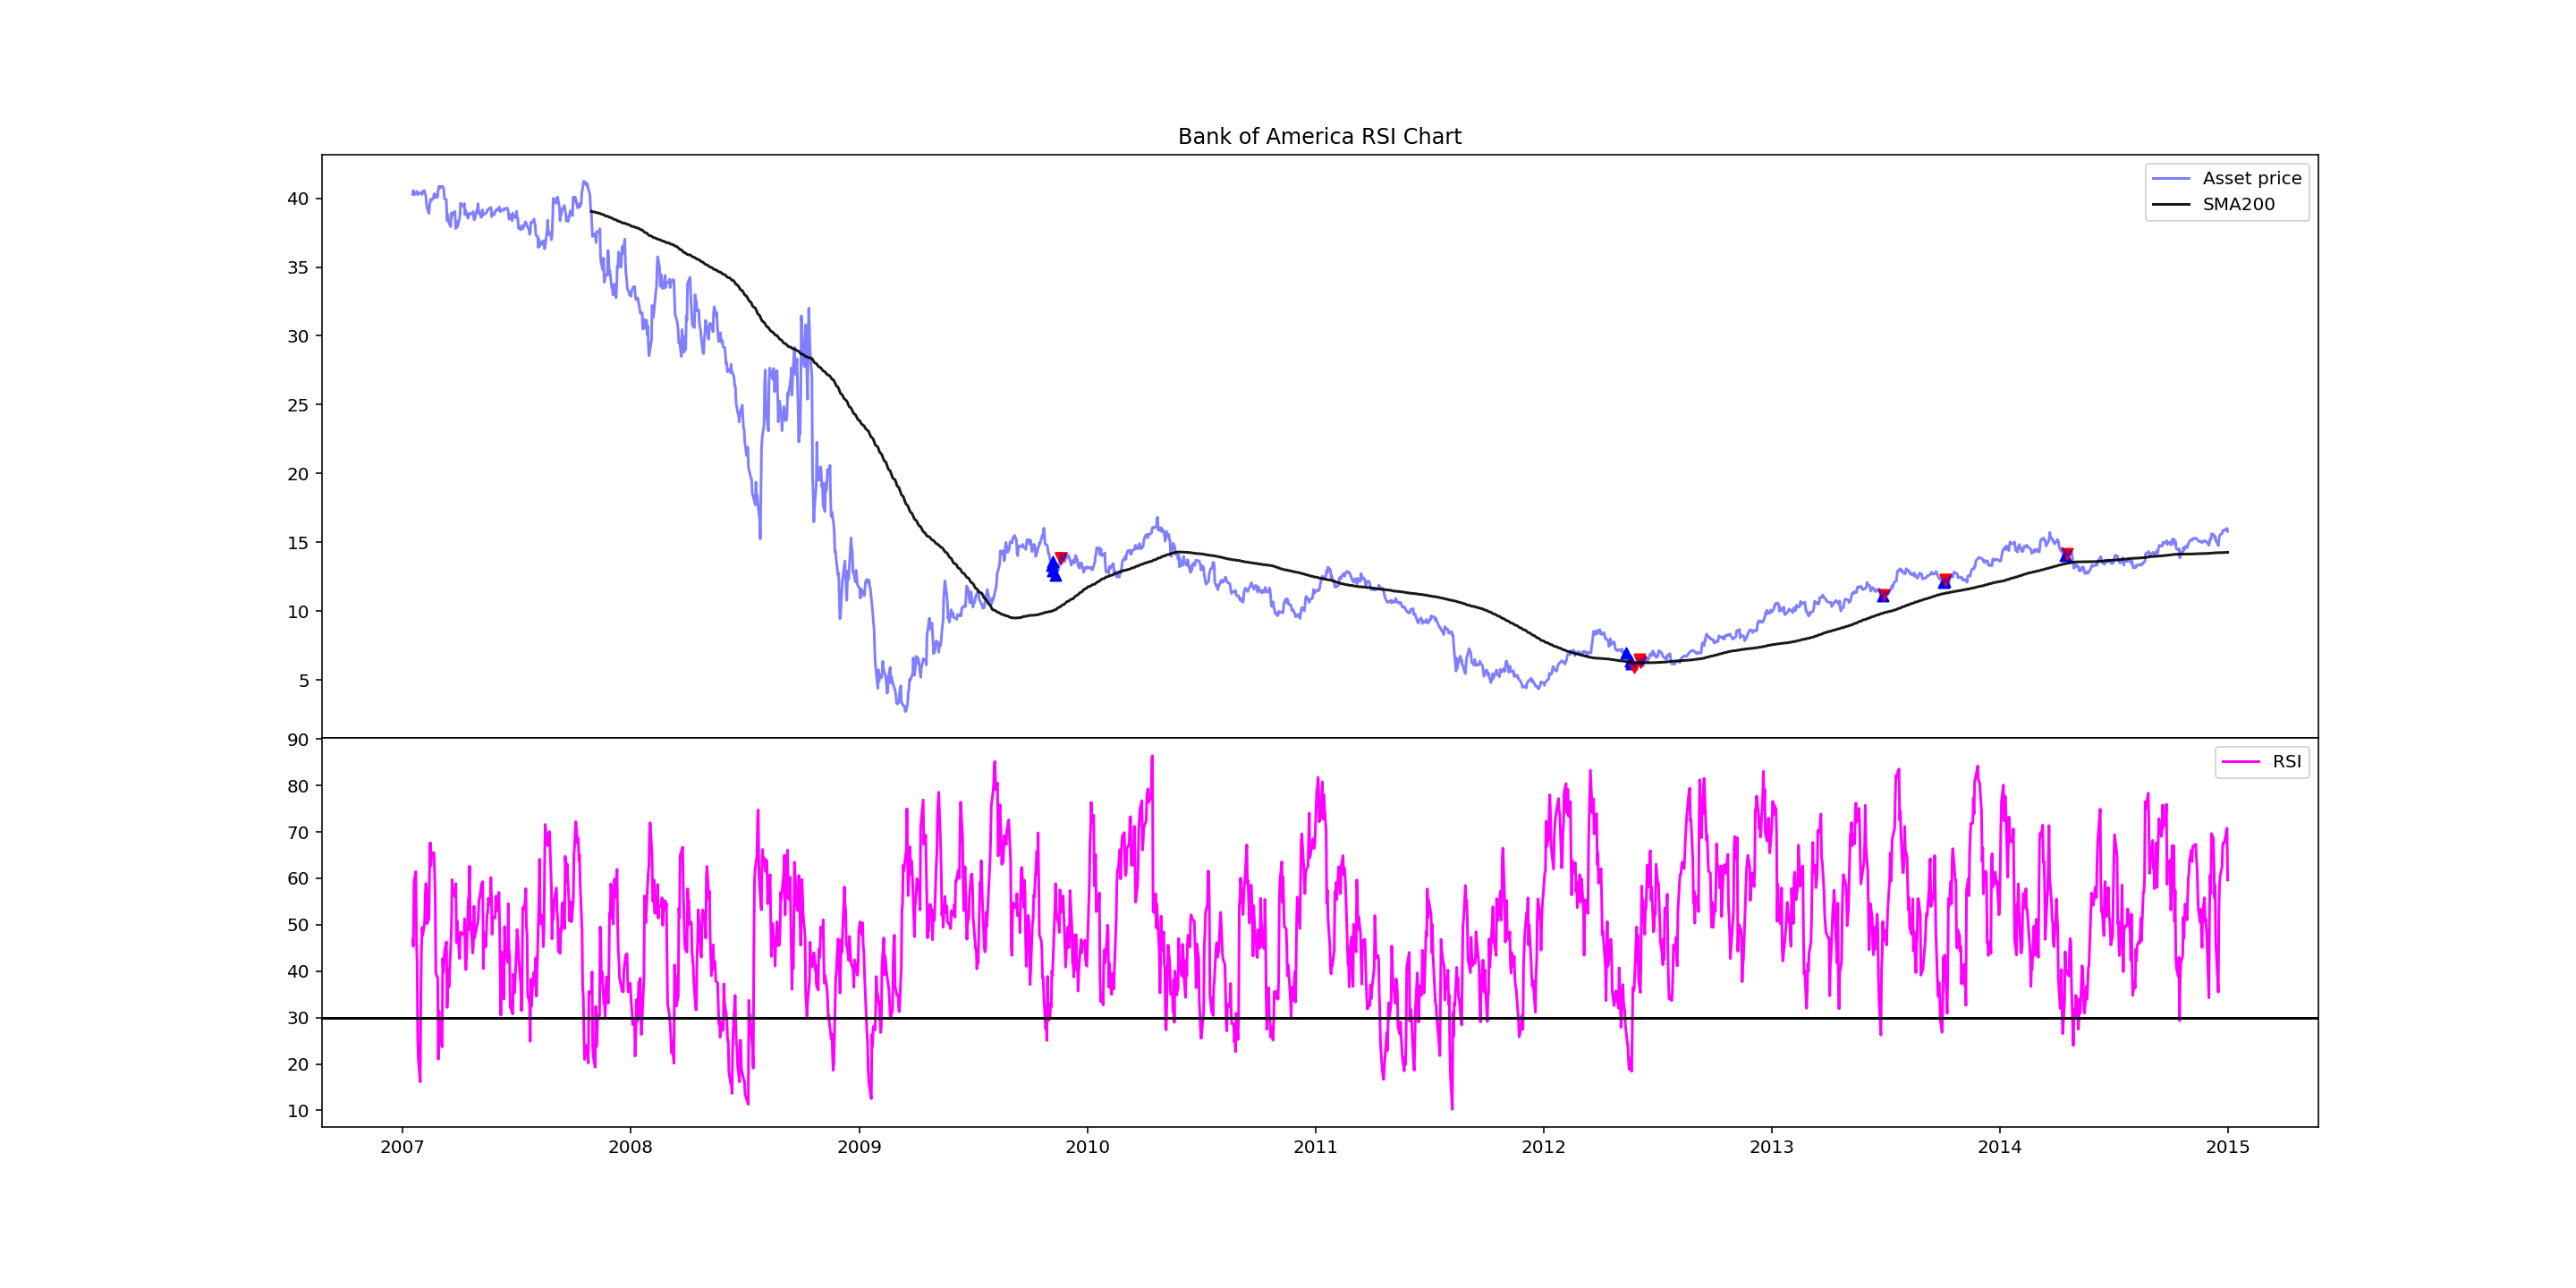
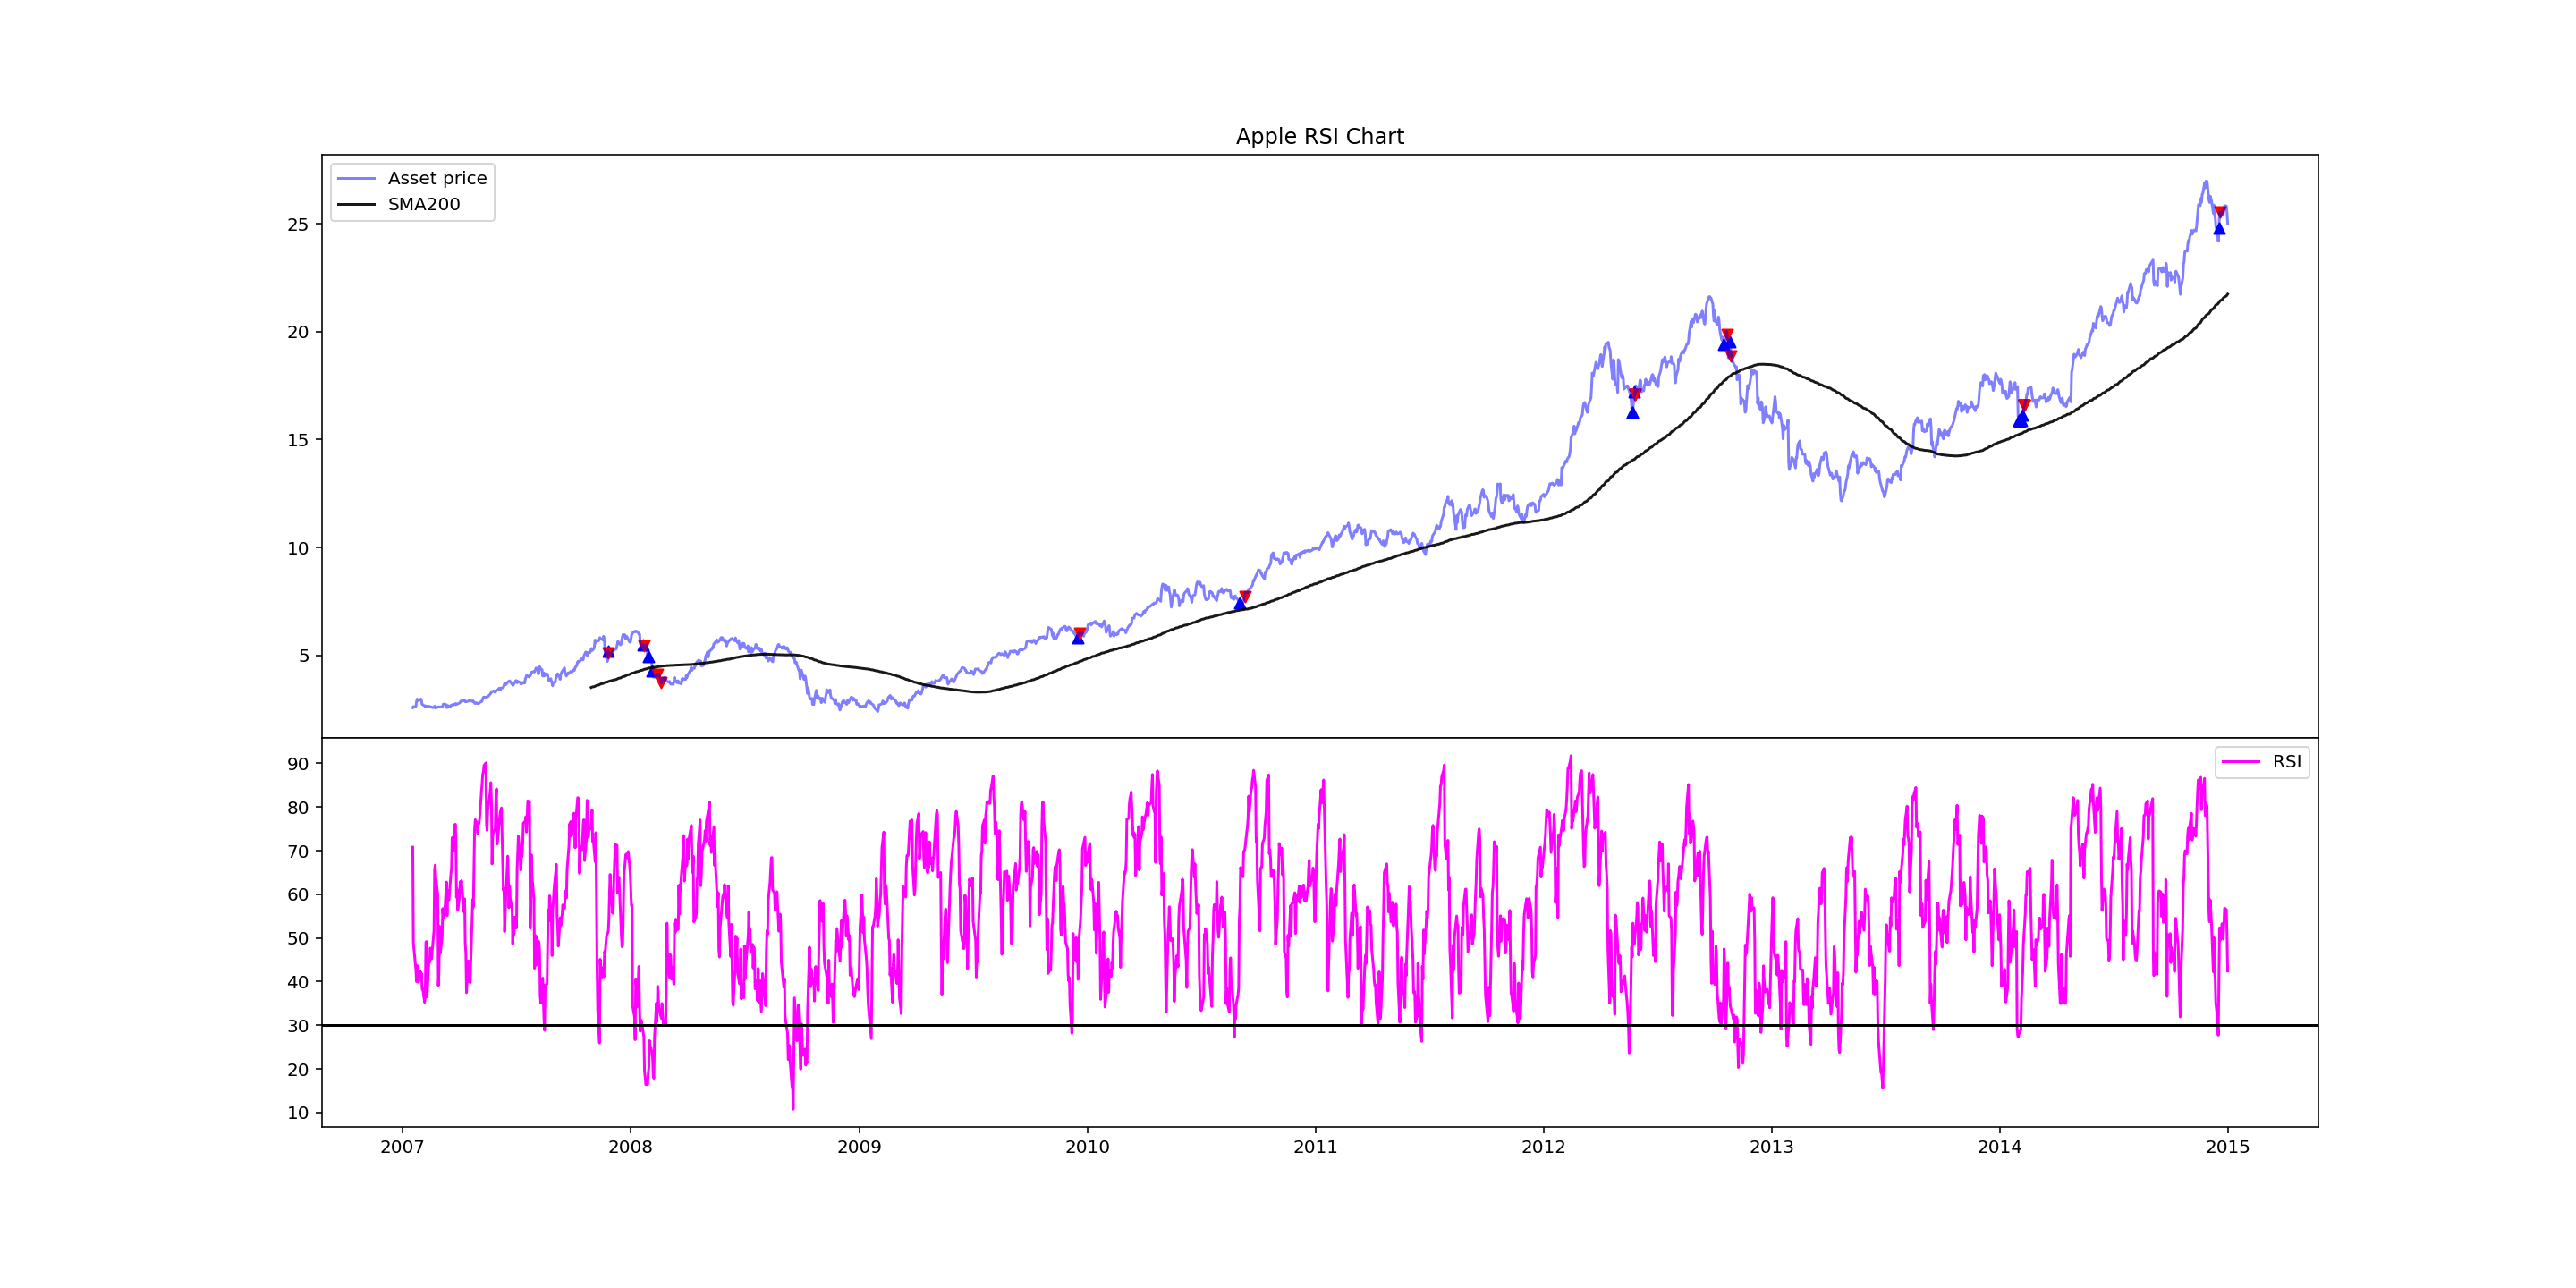
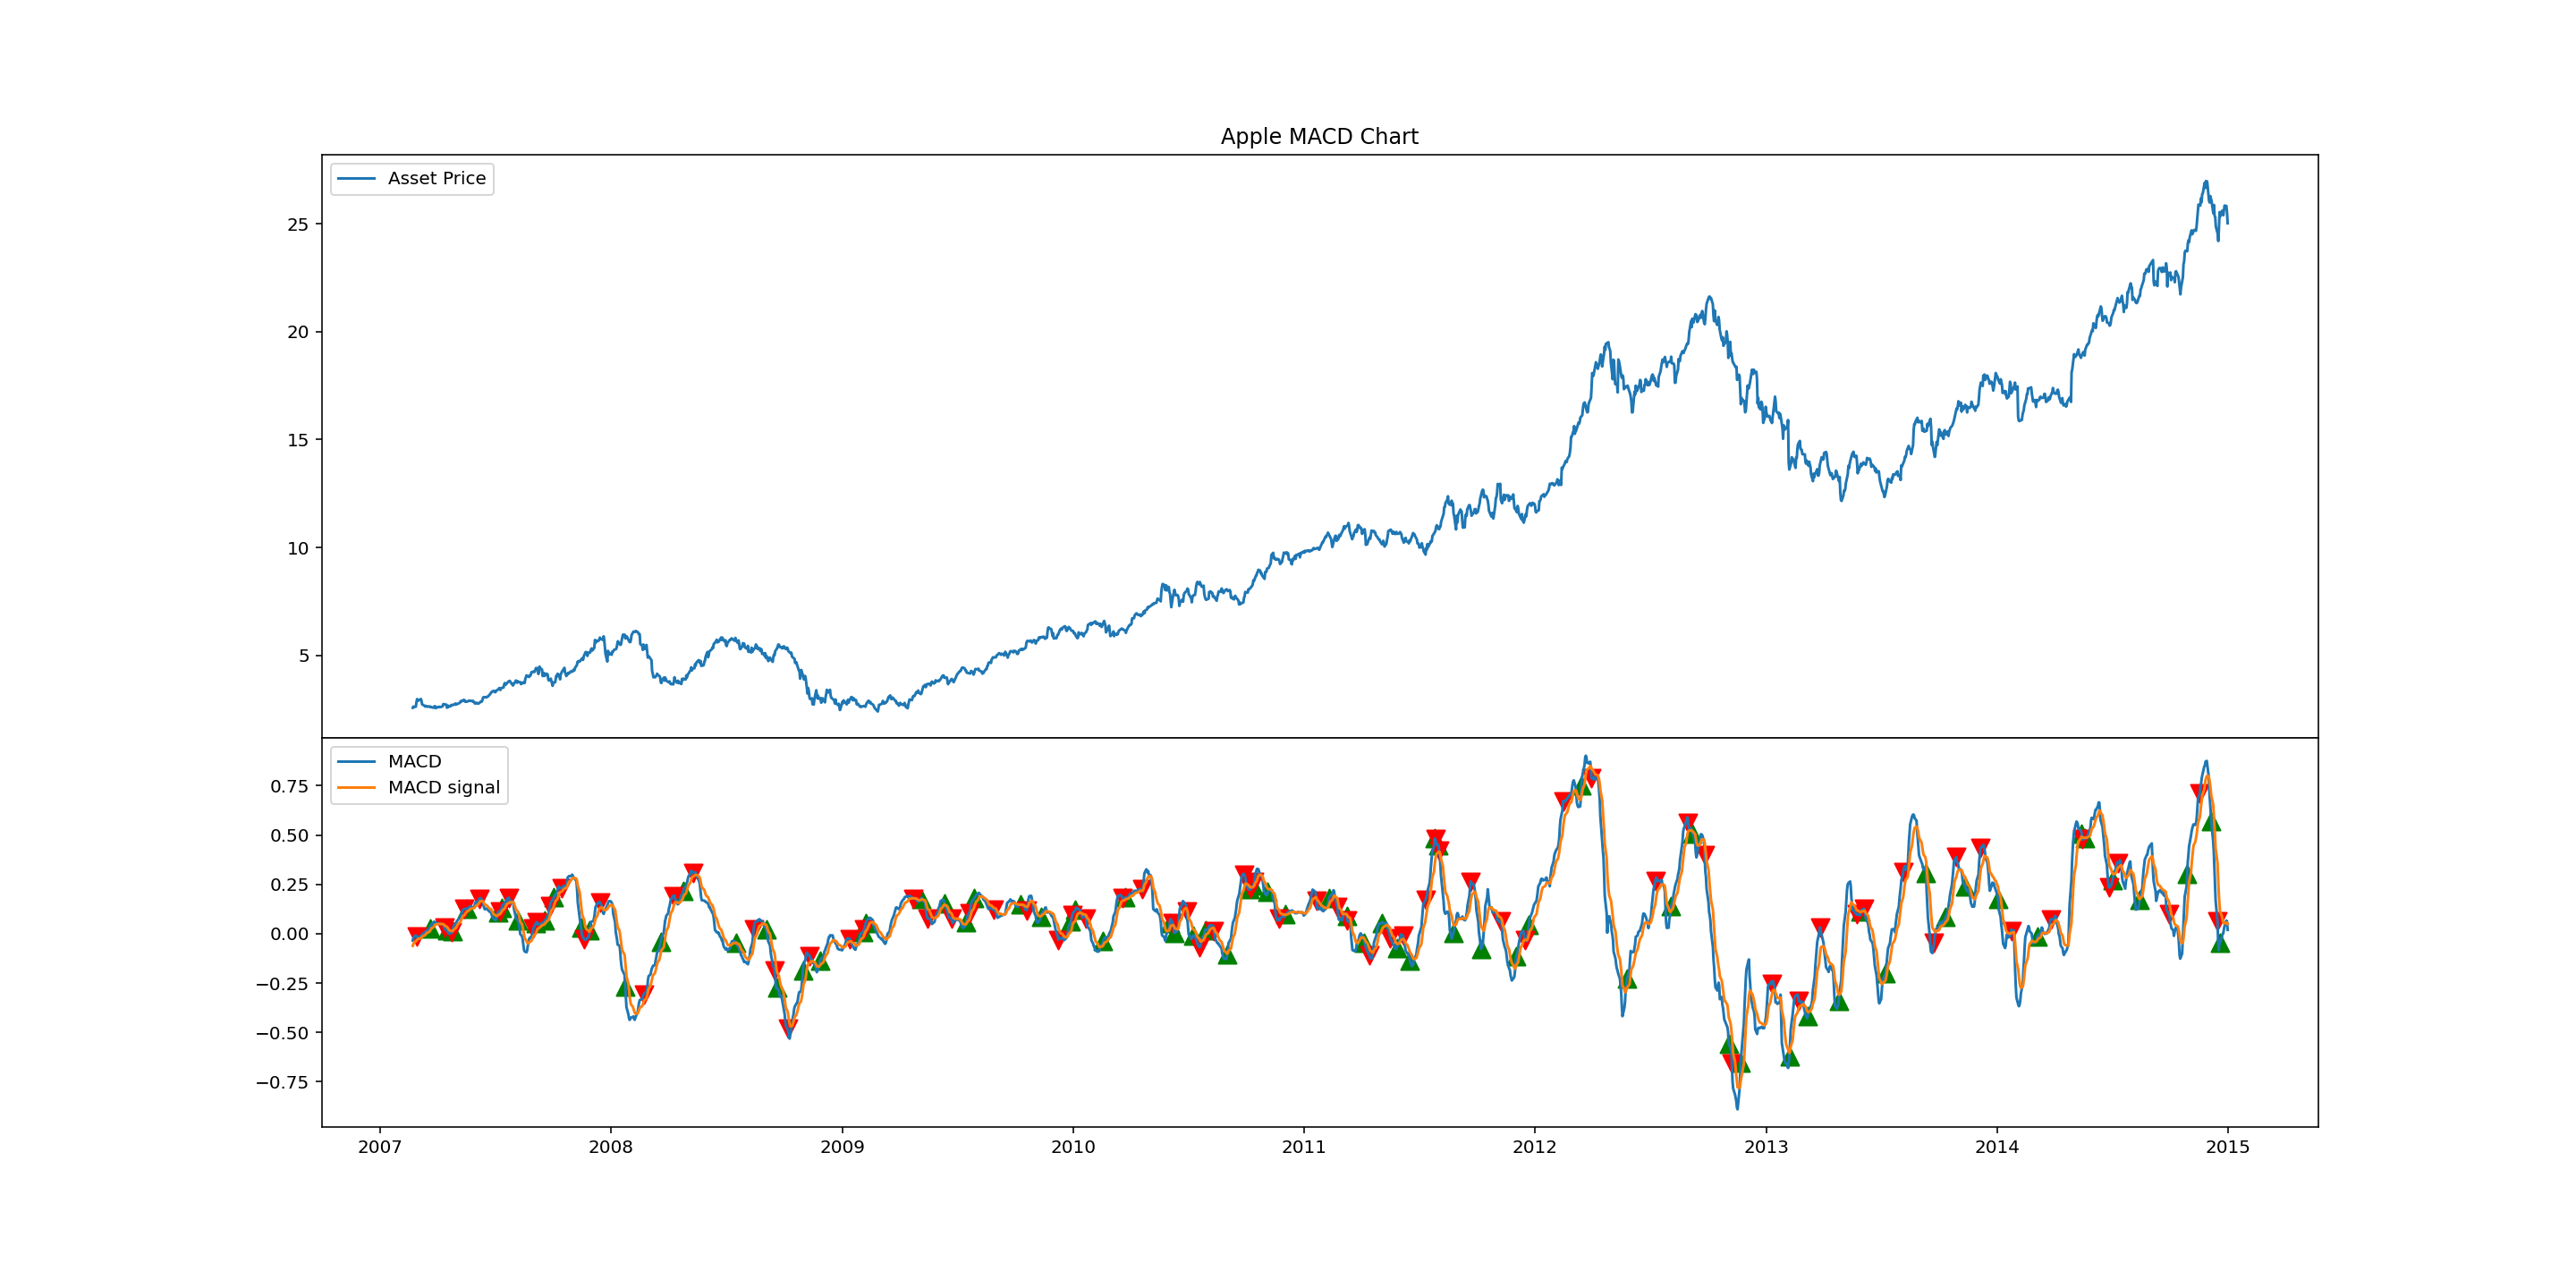
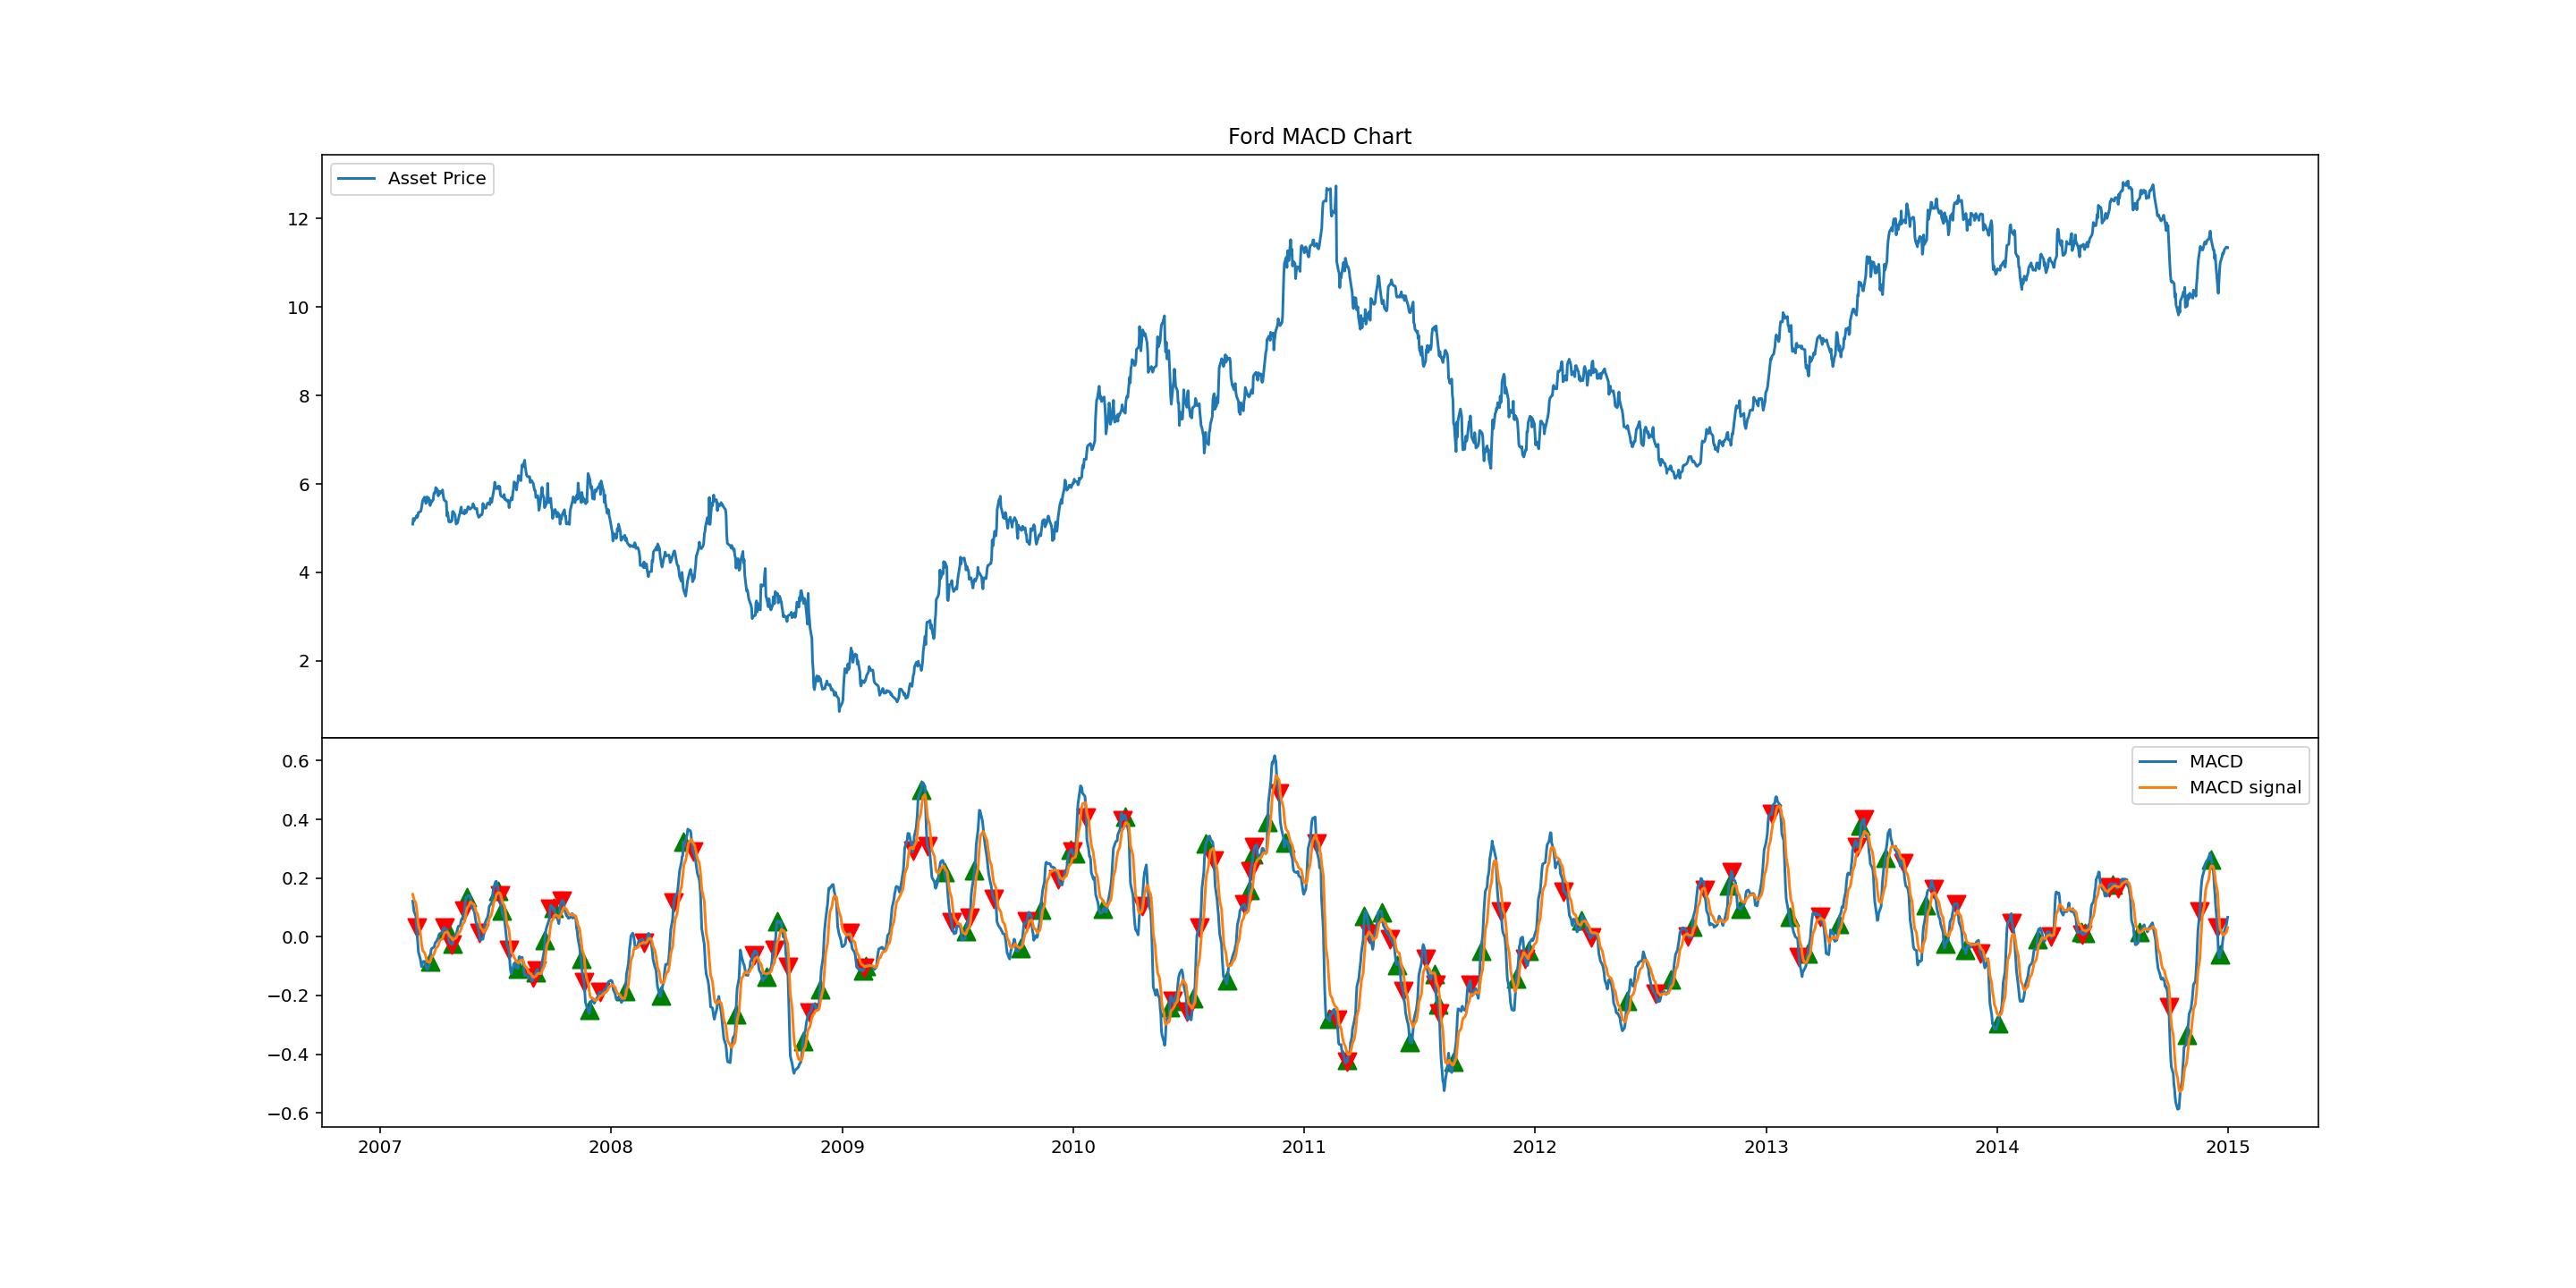
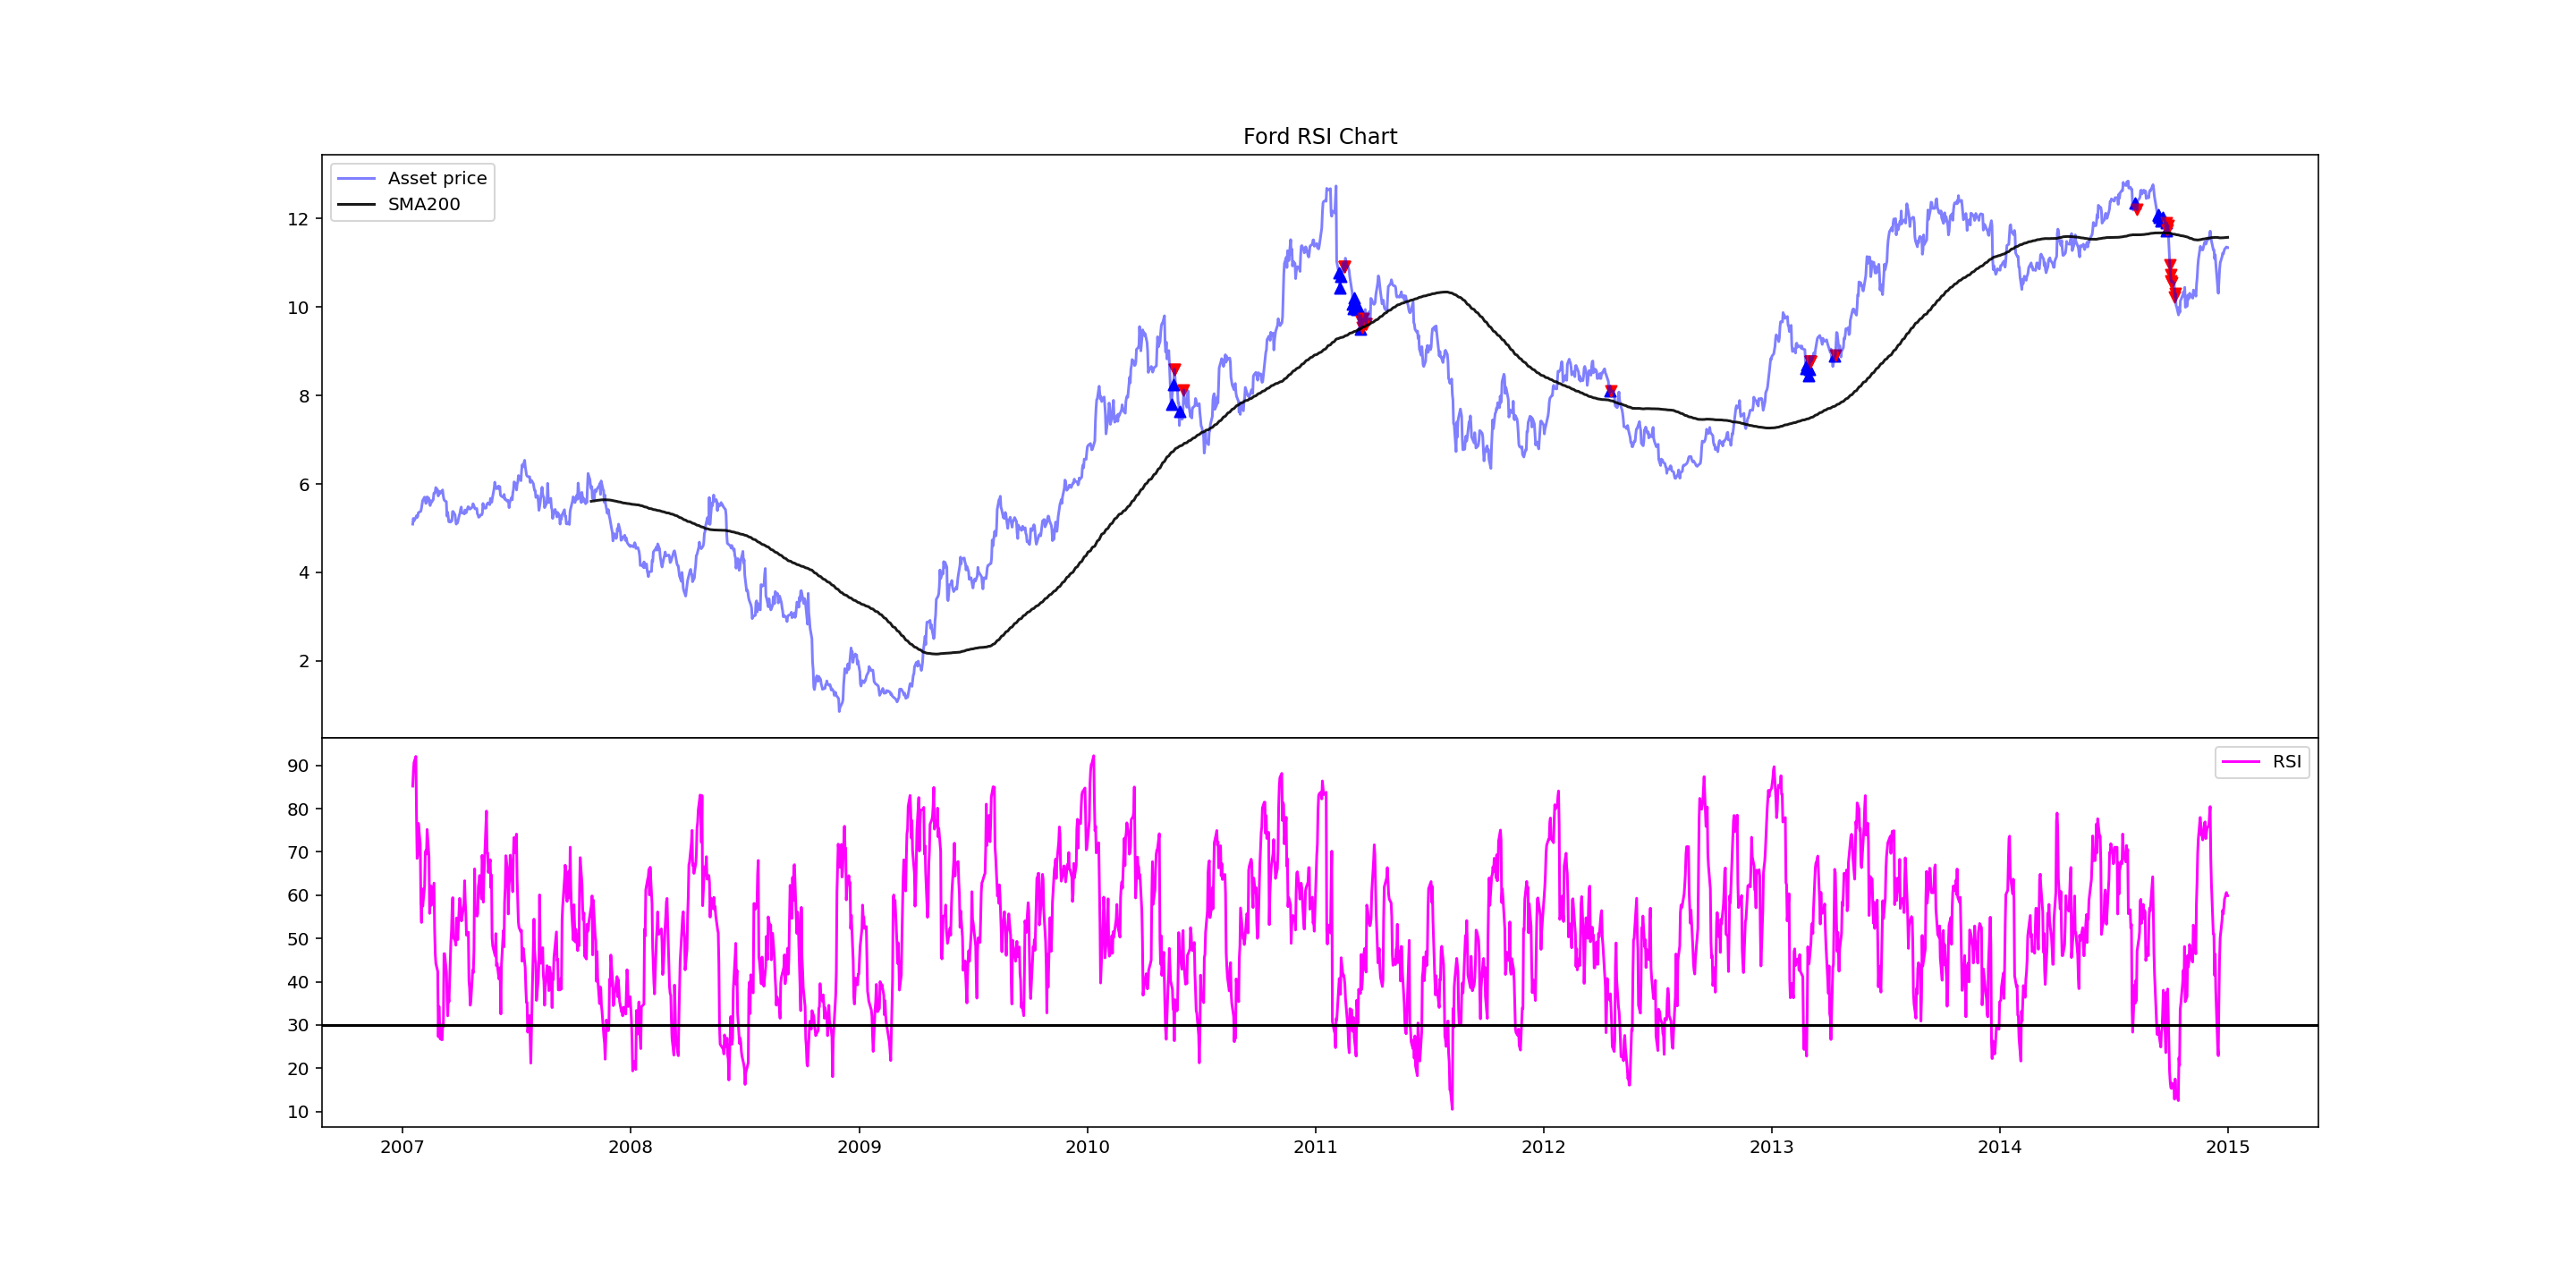
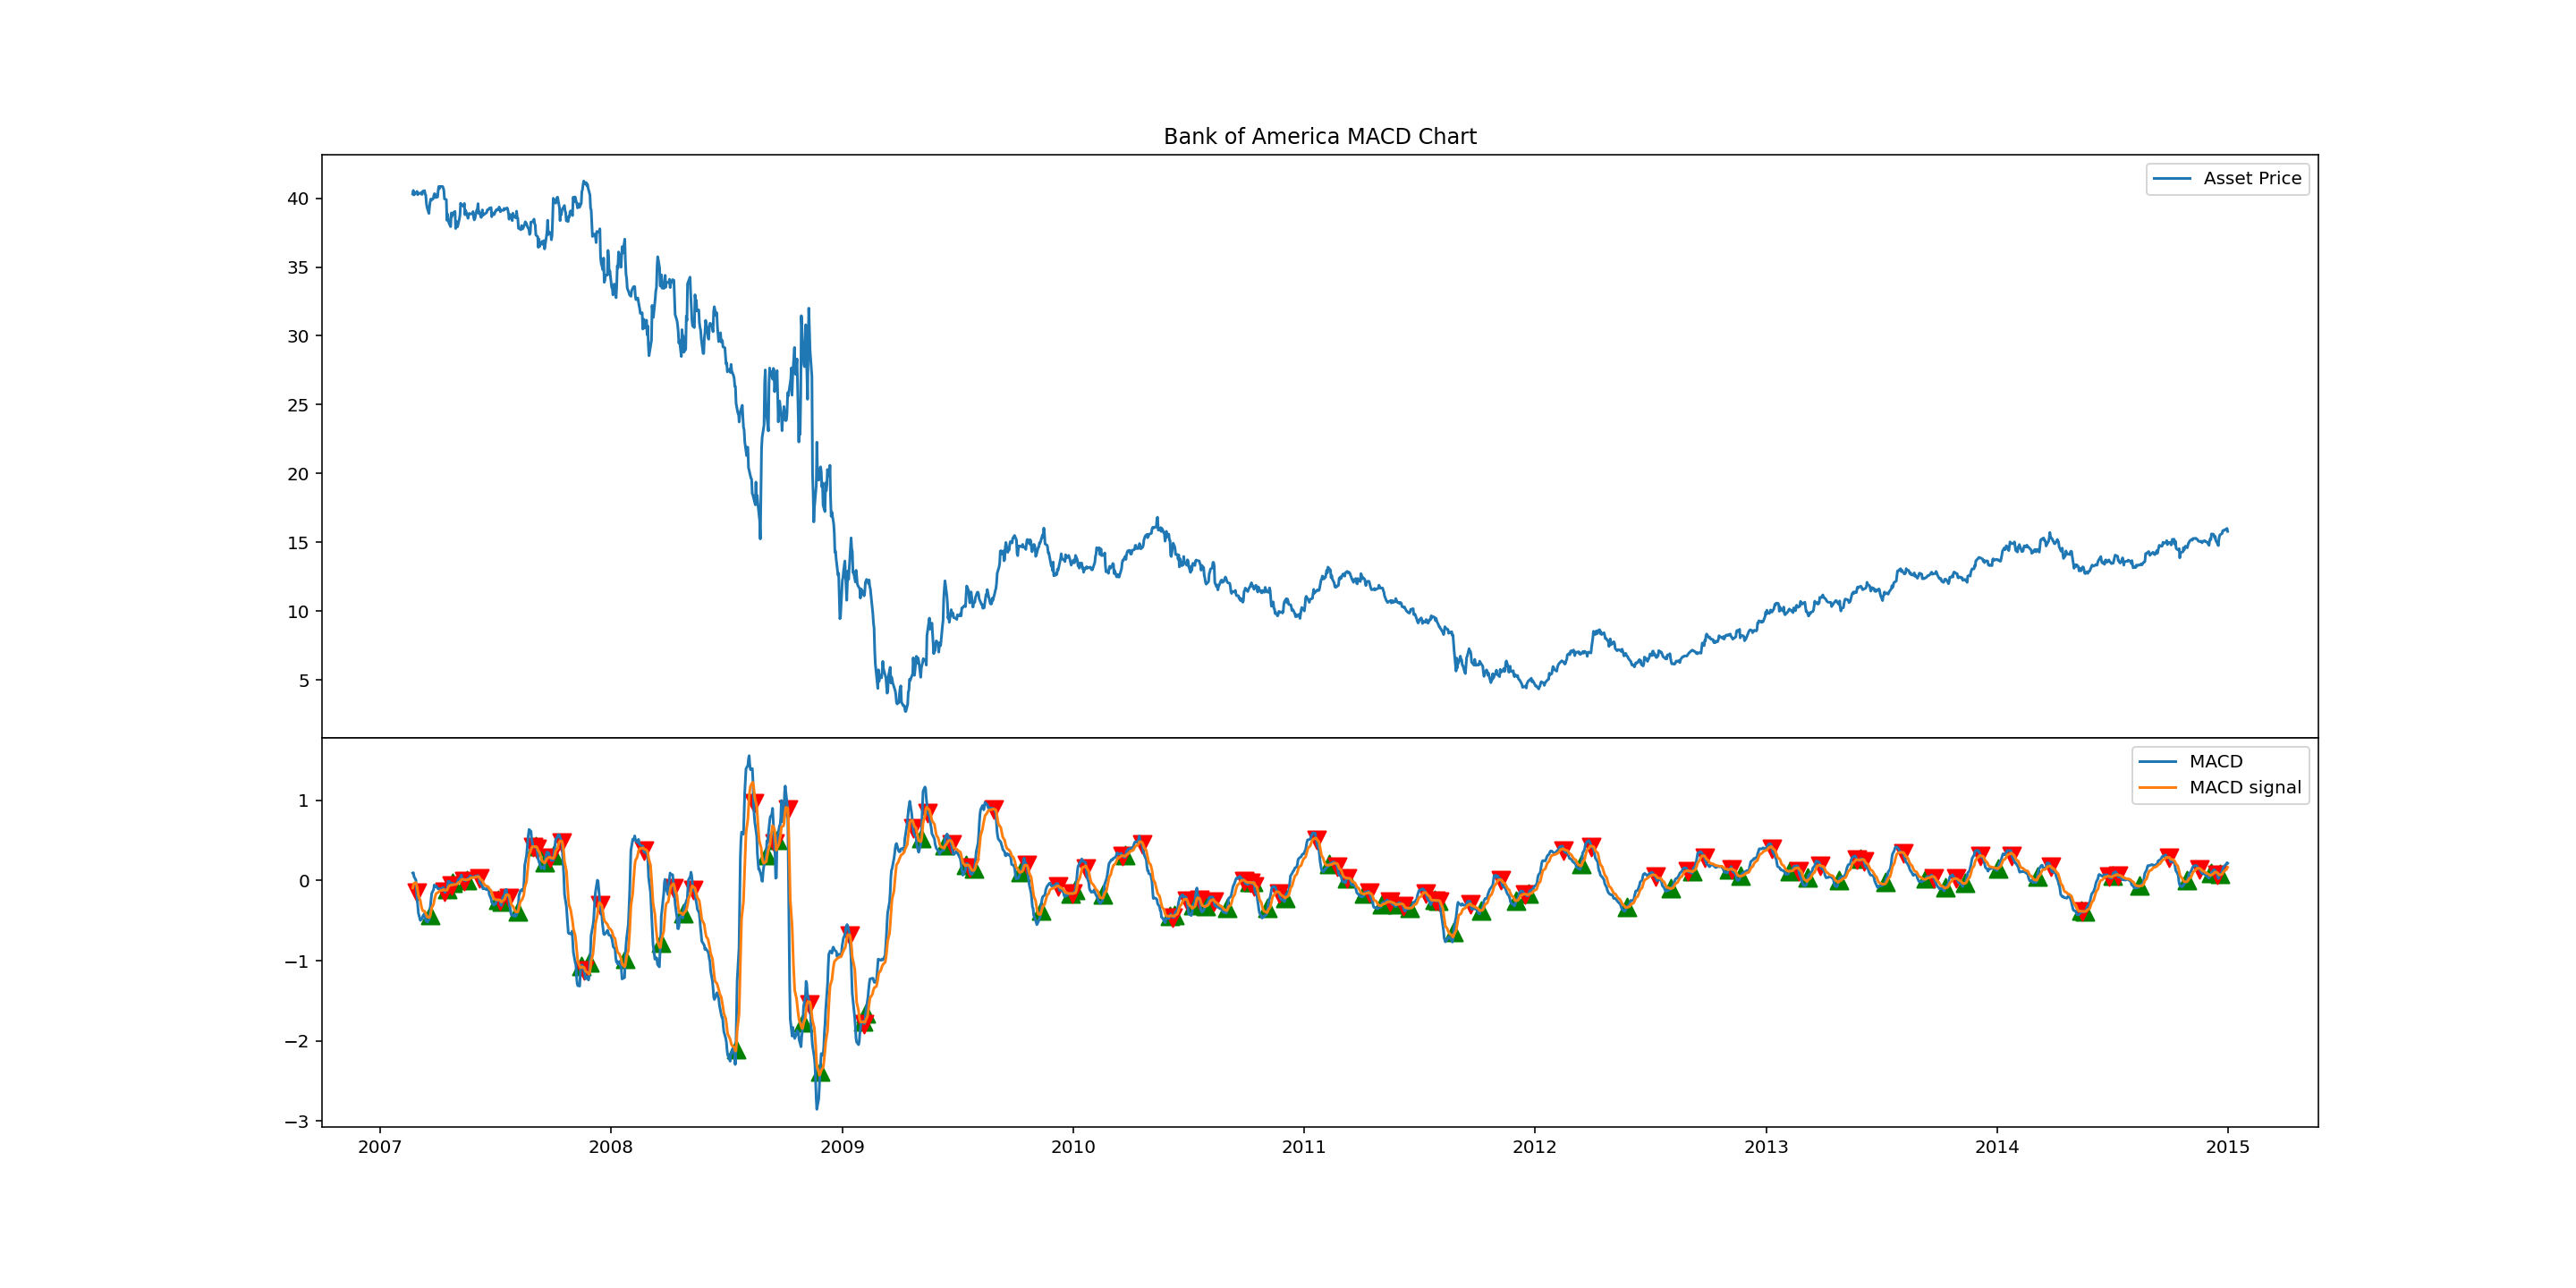
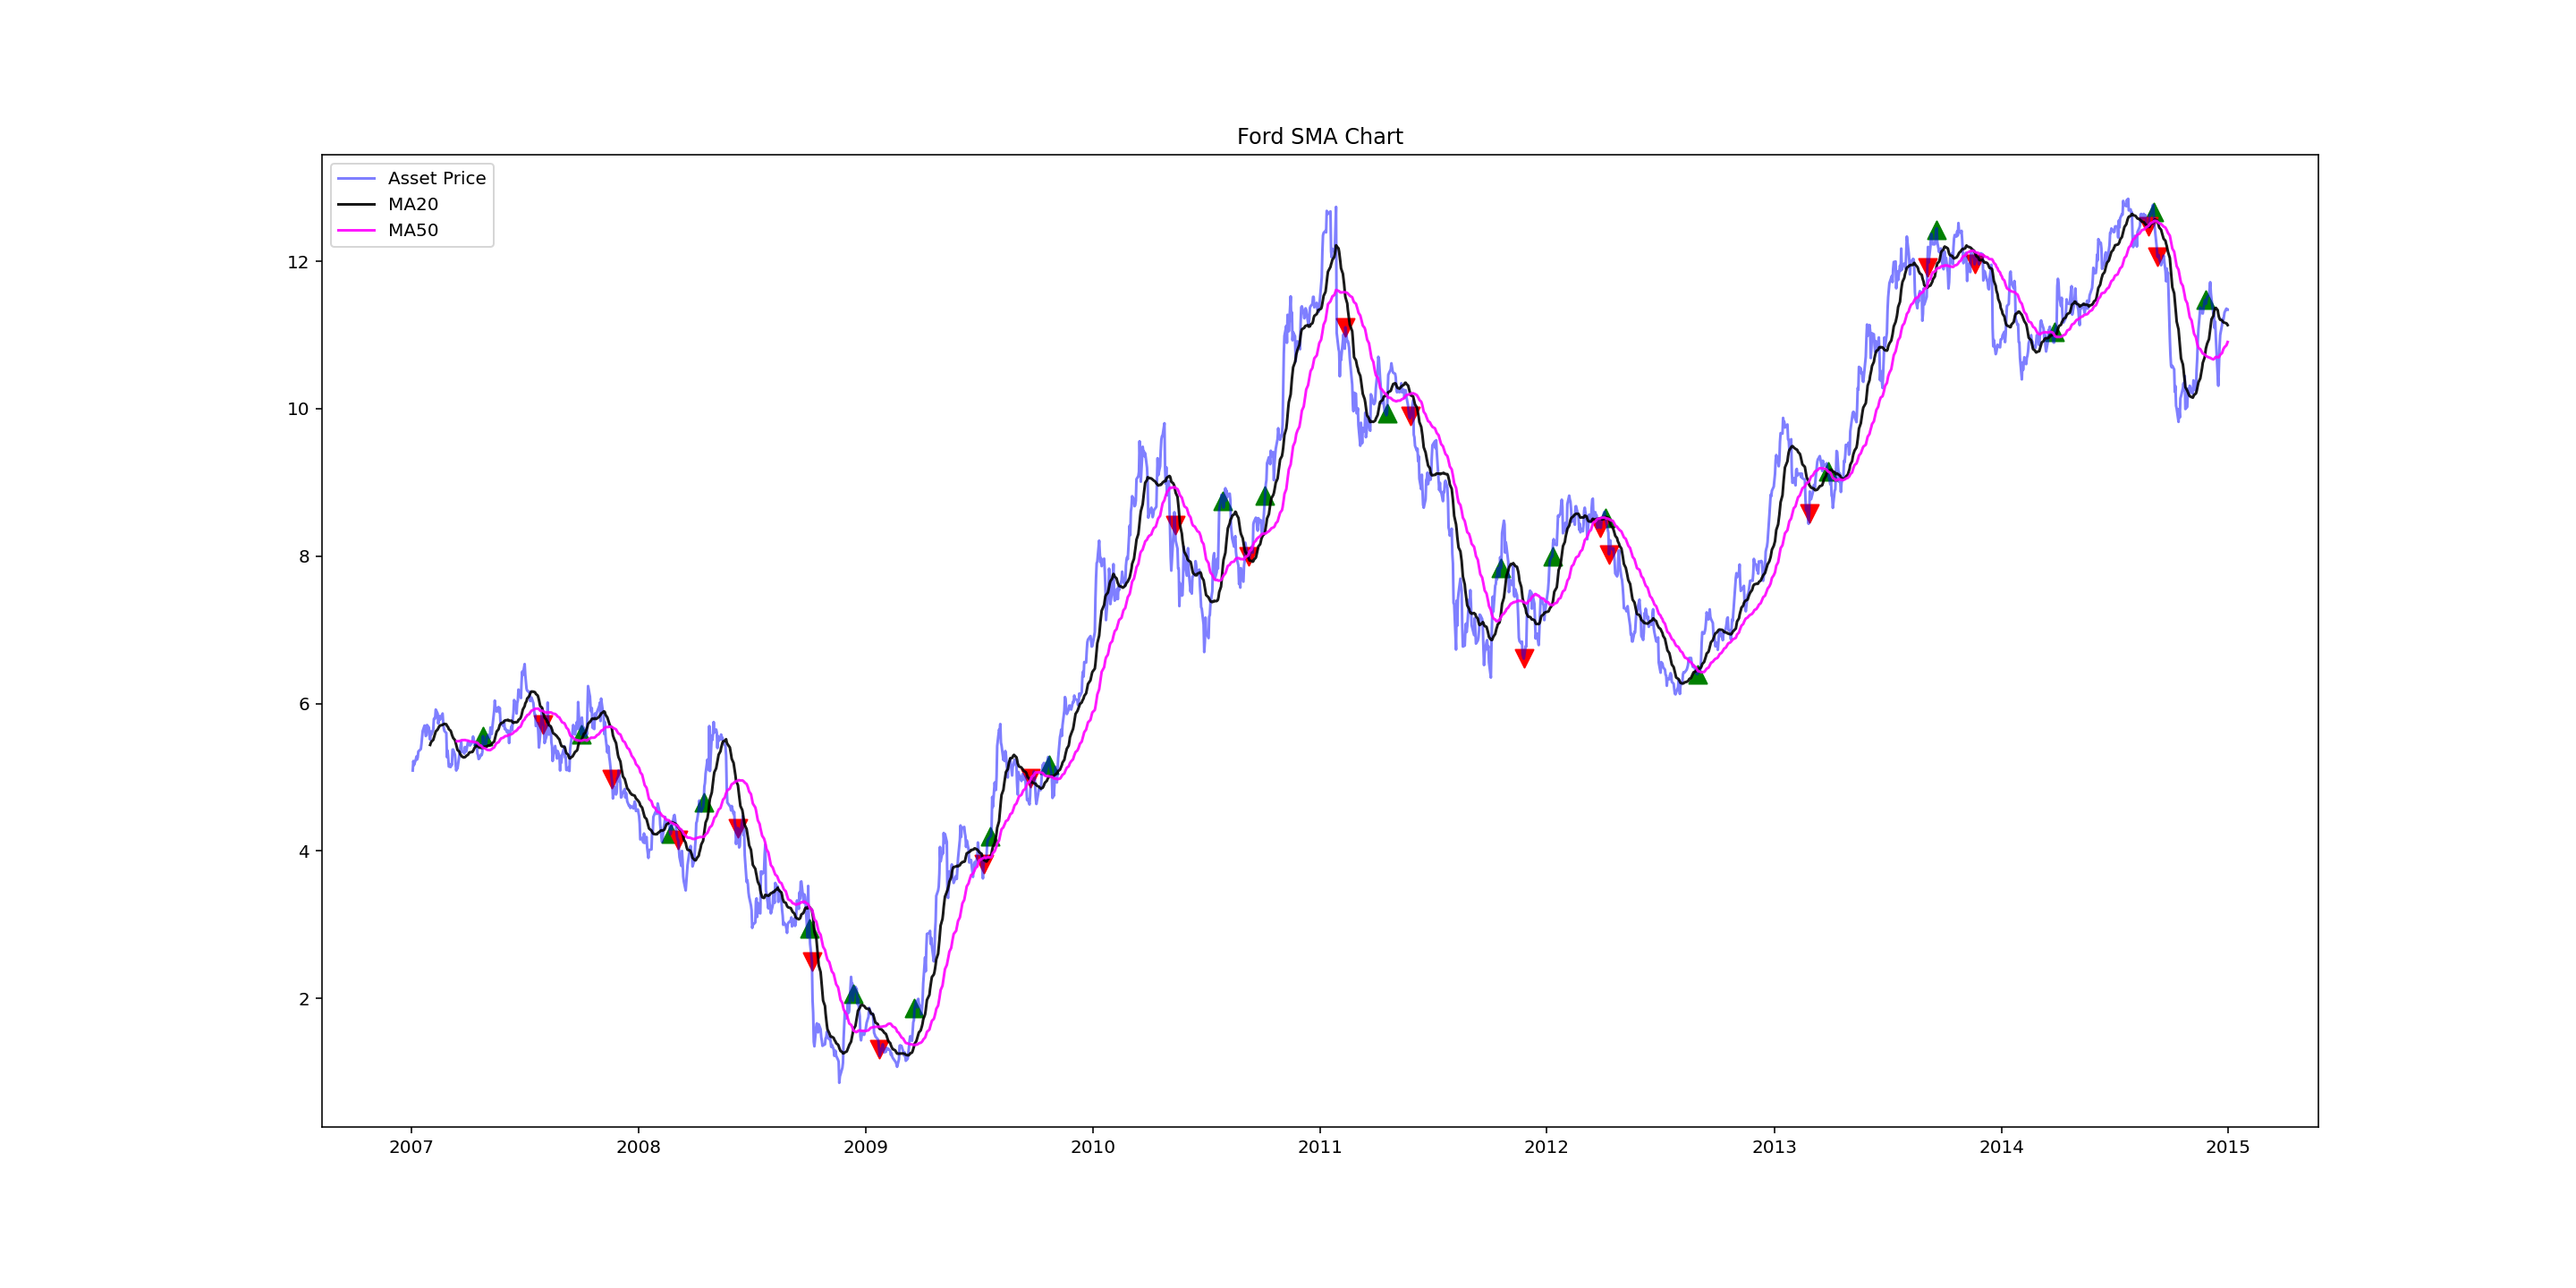
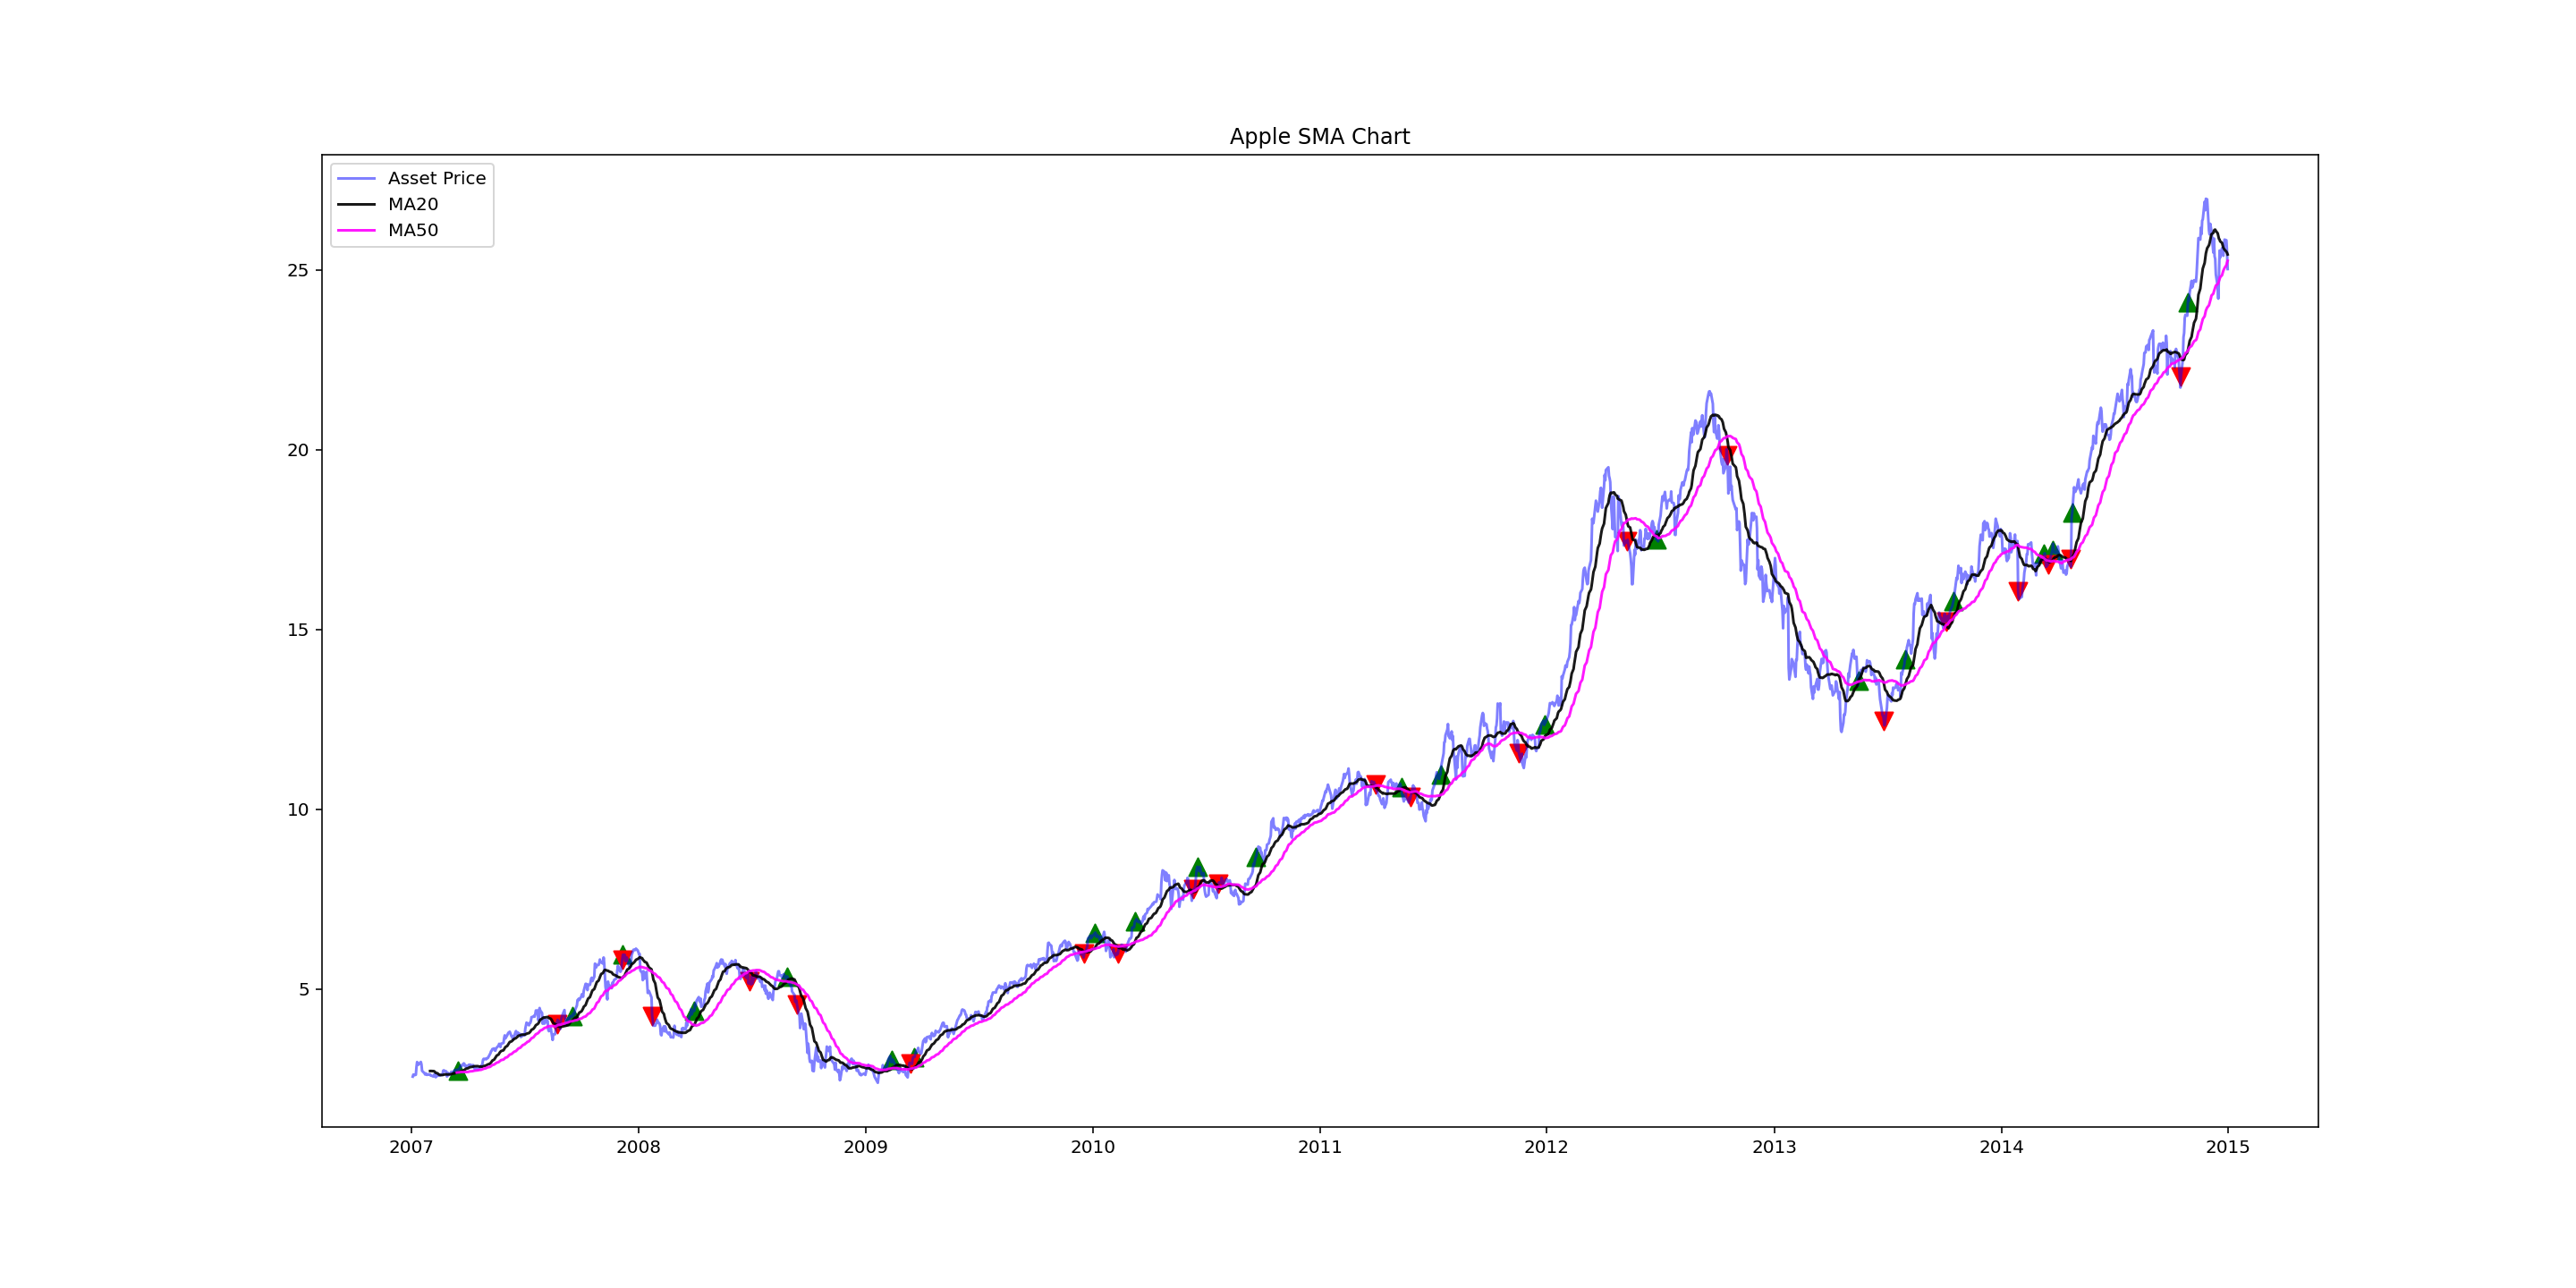

In [11]:
#Dashboard
Title =  pn.pane.Markdown(
    "## Backtesting with Python", width=700
)


apple_col = pn.Column(apple_sma(), apple_macd(), apple_rsi())
ford_col = pn.Column(ford_sma(), ford_macd(), ford_rsi())
bac_col = pn.Column(bac_sma(), bac_macd(), bac_rsi())
return_col = pn.Column(returns[0].hvplot.bar(title='Apple Return', height=400),
                    returns[1].hvplot.bar(title='Ford Return', height=400),
                    returns[2].hvplot.bar(title='Bank of America Return', height=400))
win_col = pn.Column(wins[0].hvplot.bar(title='Apple Win Rate', height=400),
                wins[1].hvplot.bar(title='Ford Win Rate', height=400),
                wins[2].hvplot.bar(title='Bank of America Win Rate', height=400))

tabs = pn.Tabs(('Apple with Buy/Sell signals', apple_col), 
               ('Ford with Buy/Sell signals', ford_col),
               ('Bank of America with Buy/Sell signals', bac_col),
               ('Comparing returns for strategies', return_col), 
               ('Comparing win rates for strategies', win_col))

dashboard = pn.Column(pn.Row(Title),
"""At the end of the day, investors and traders are here to make money and people claim all the time that they can beat the market. \n
   Our goal was to find out whether we could optimise our profits in a way that was considerably better than just buying and holding those assets over the same period.
""",
               tabs)

dashboard

Column
    [0] Row
        [0] Markdown(str, width=700)
    [1] Markdown(str)
    [2] Tabs
        [0] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [1] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [2] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [3] Column
            [0] HoloViews(Bars)
            [1] HoloViews(Bars)
            [2] HoloViews(Bars)
        [4] Column
            [0] HoloViews(Bars)
            [1] HoloViews(Bars)
            [2] HoloViews(Bars)
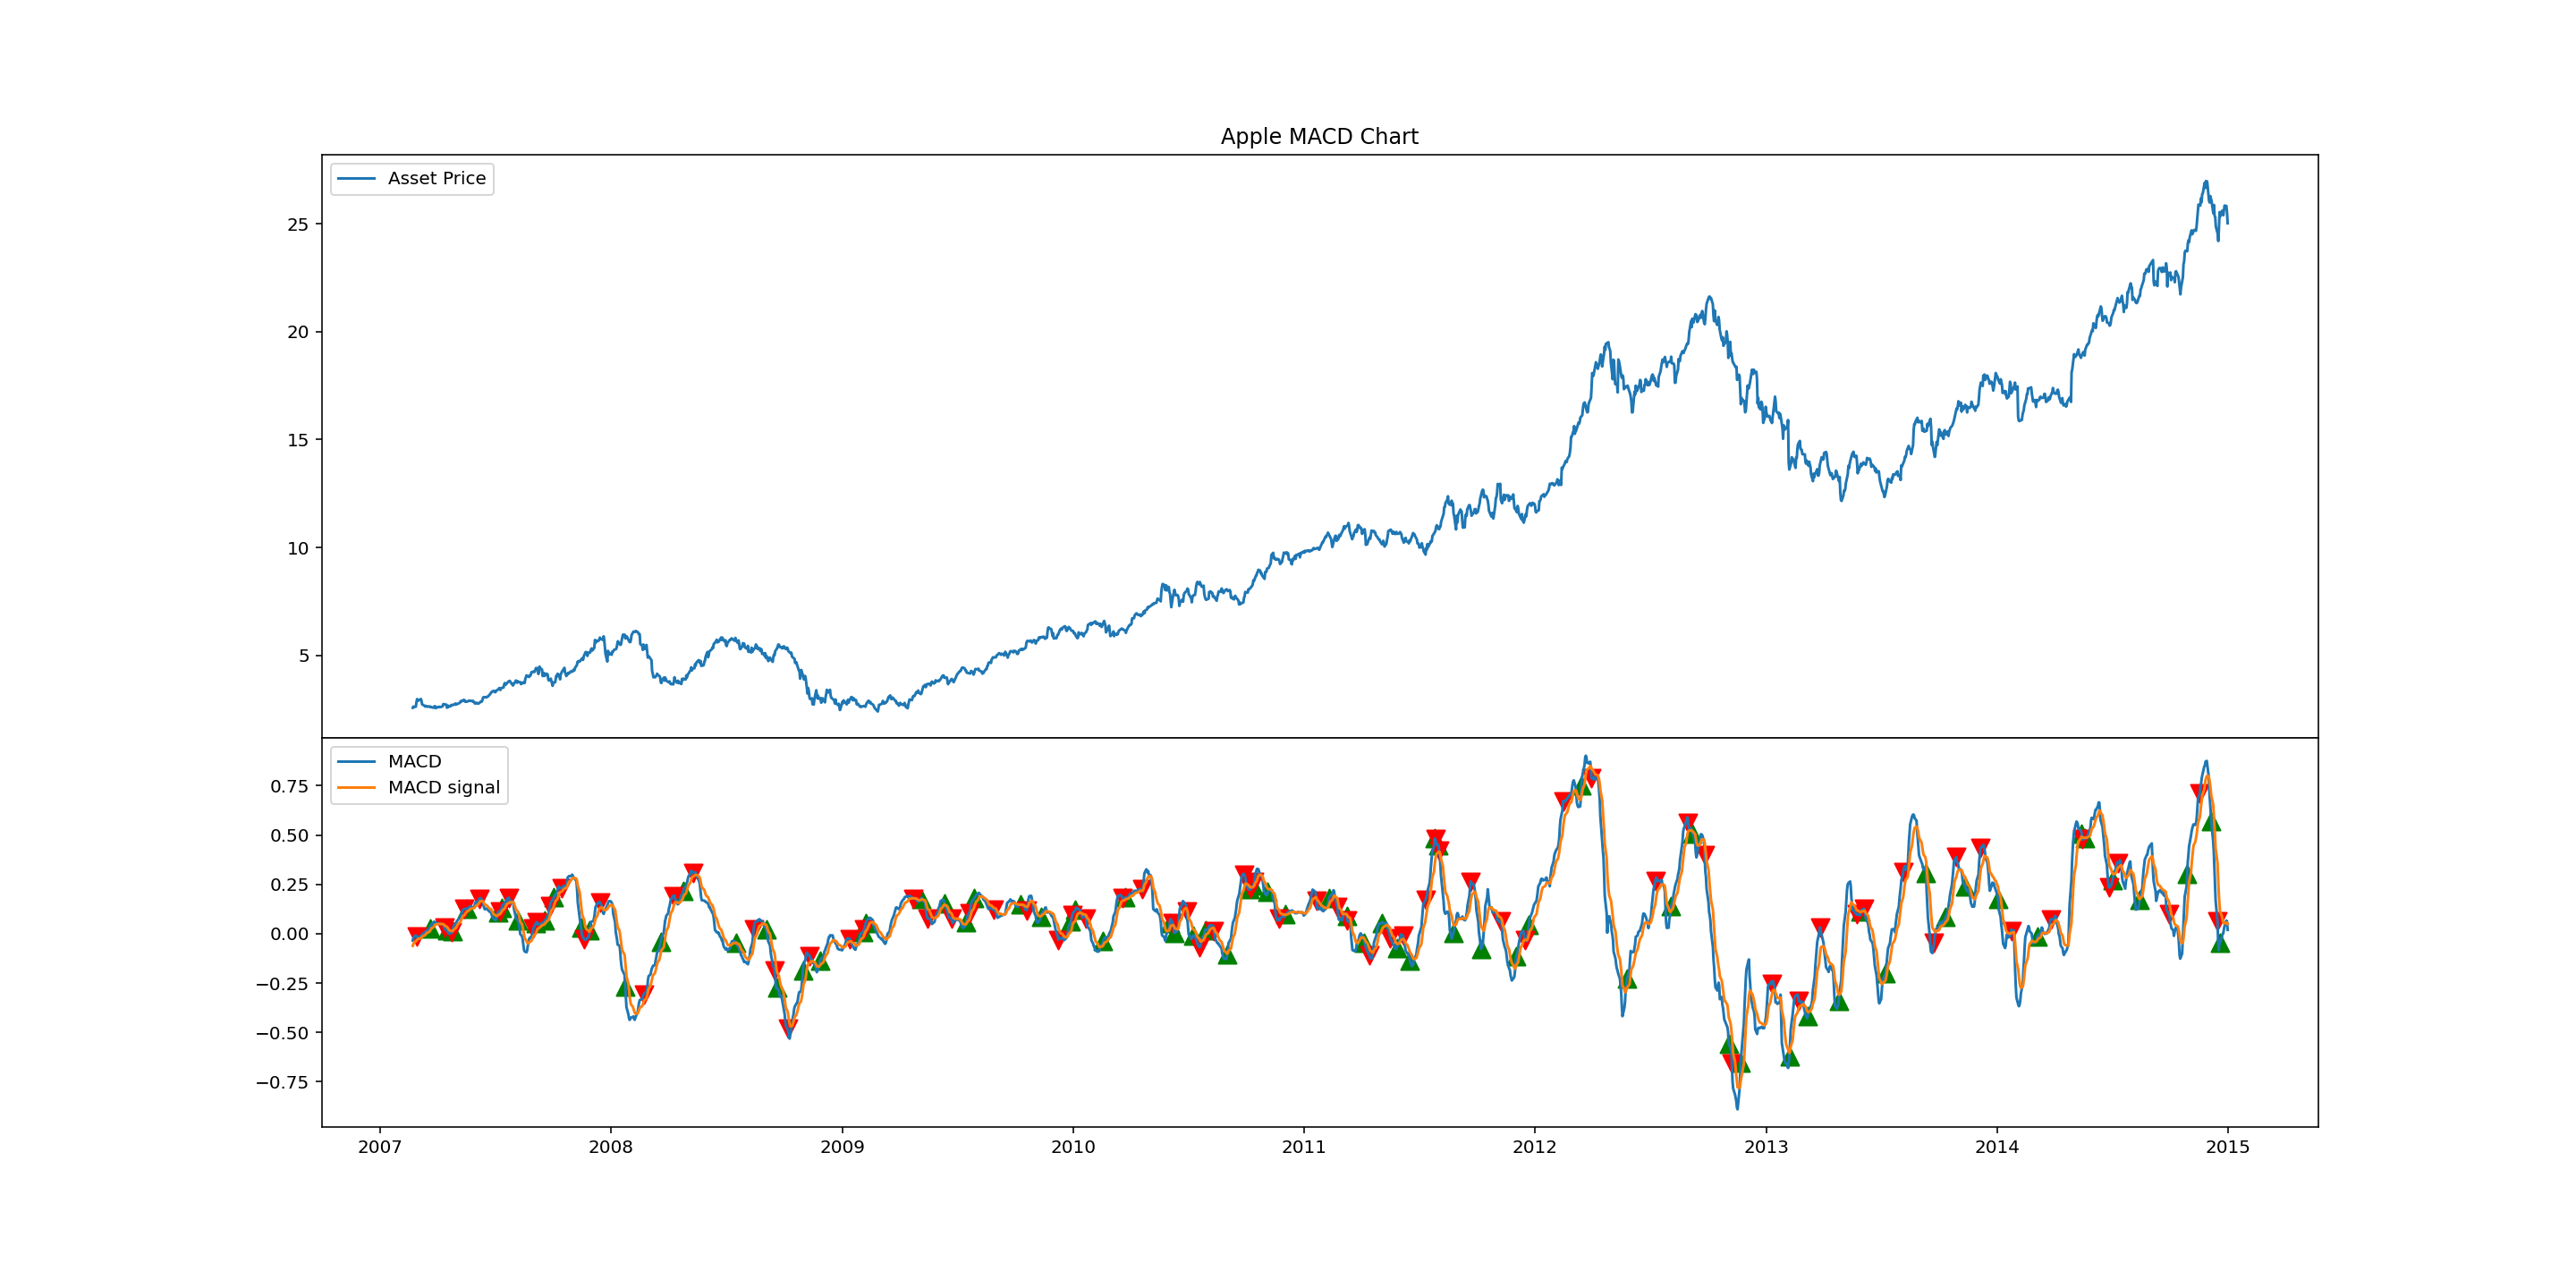
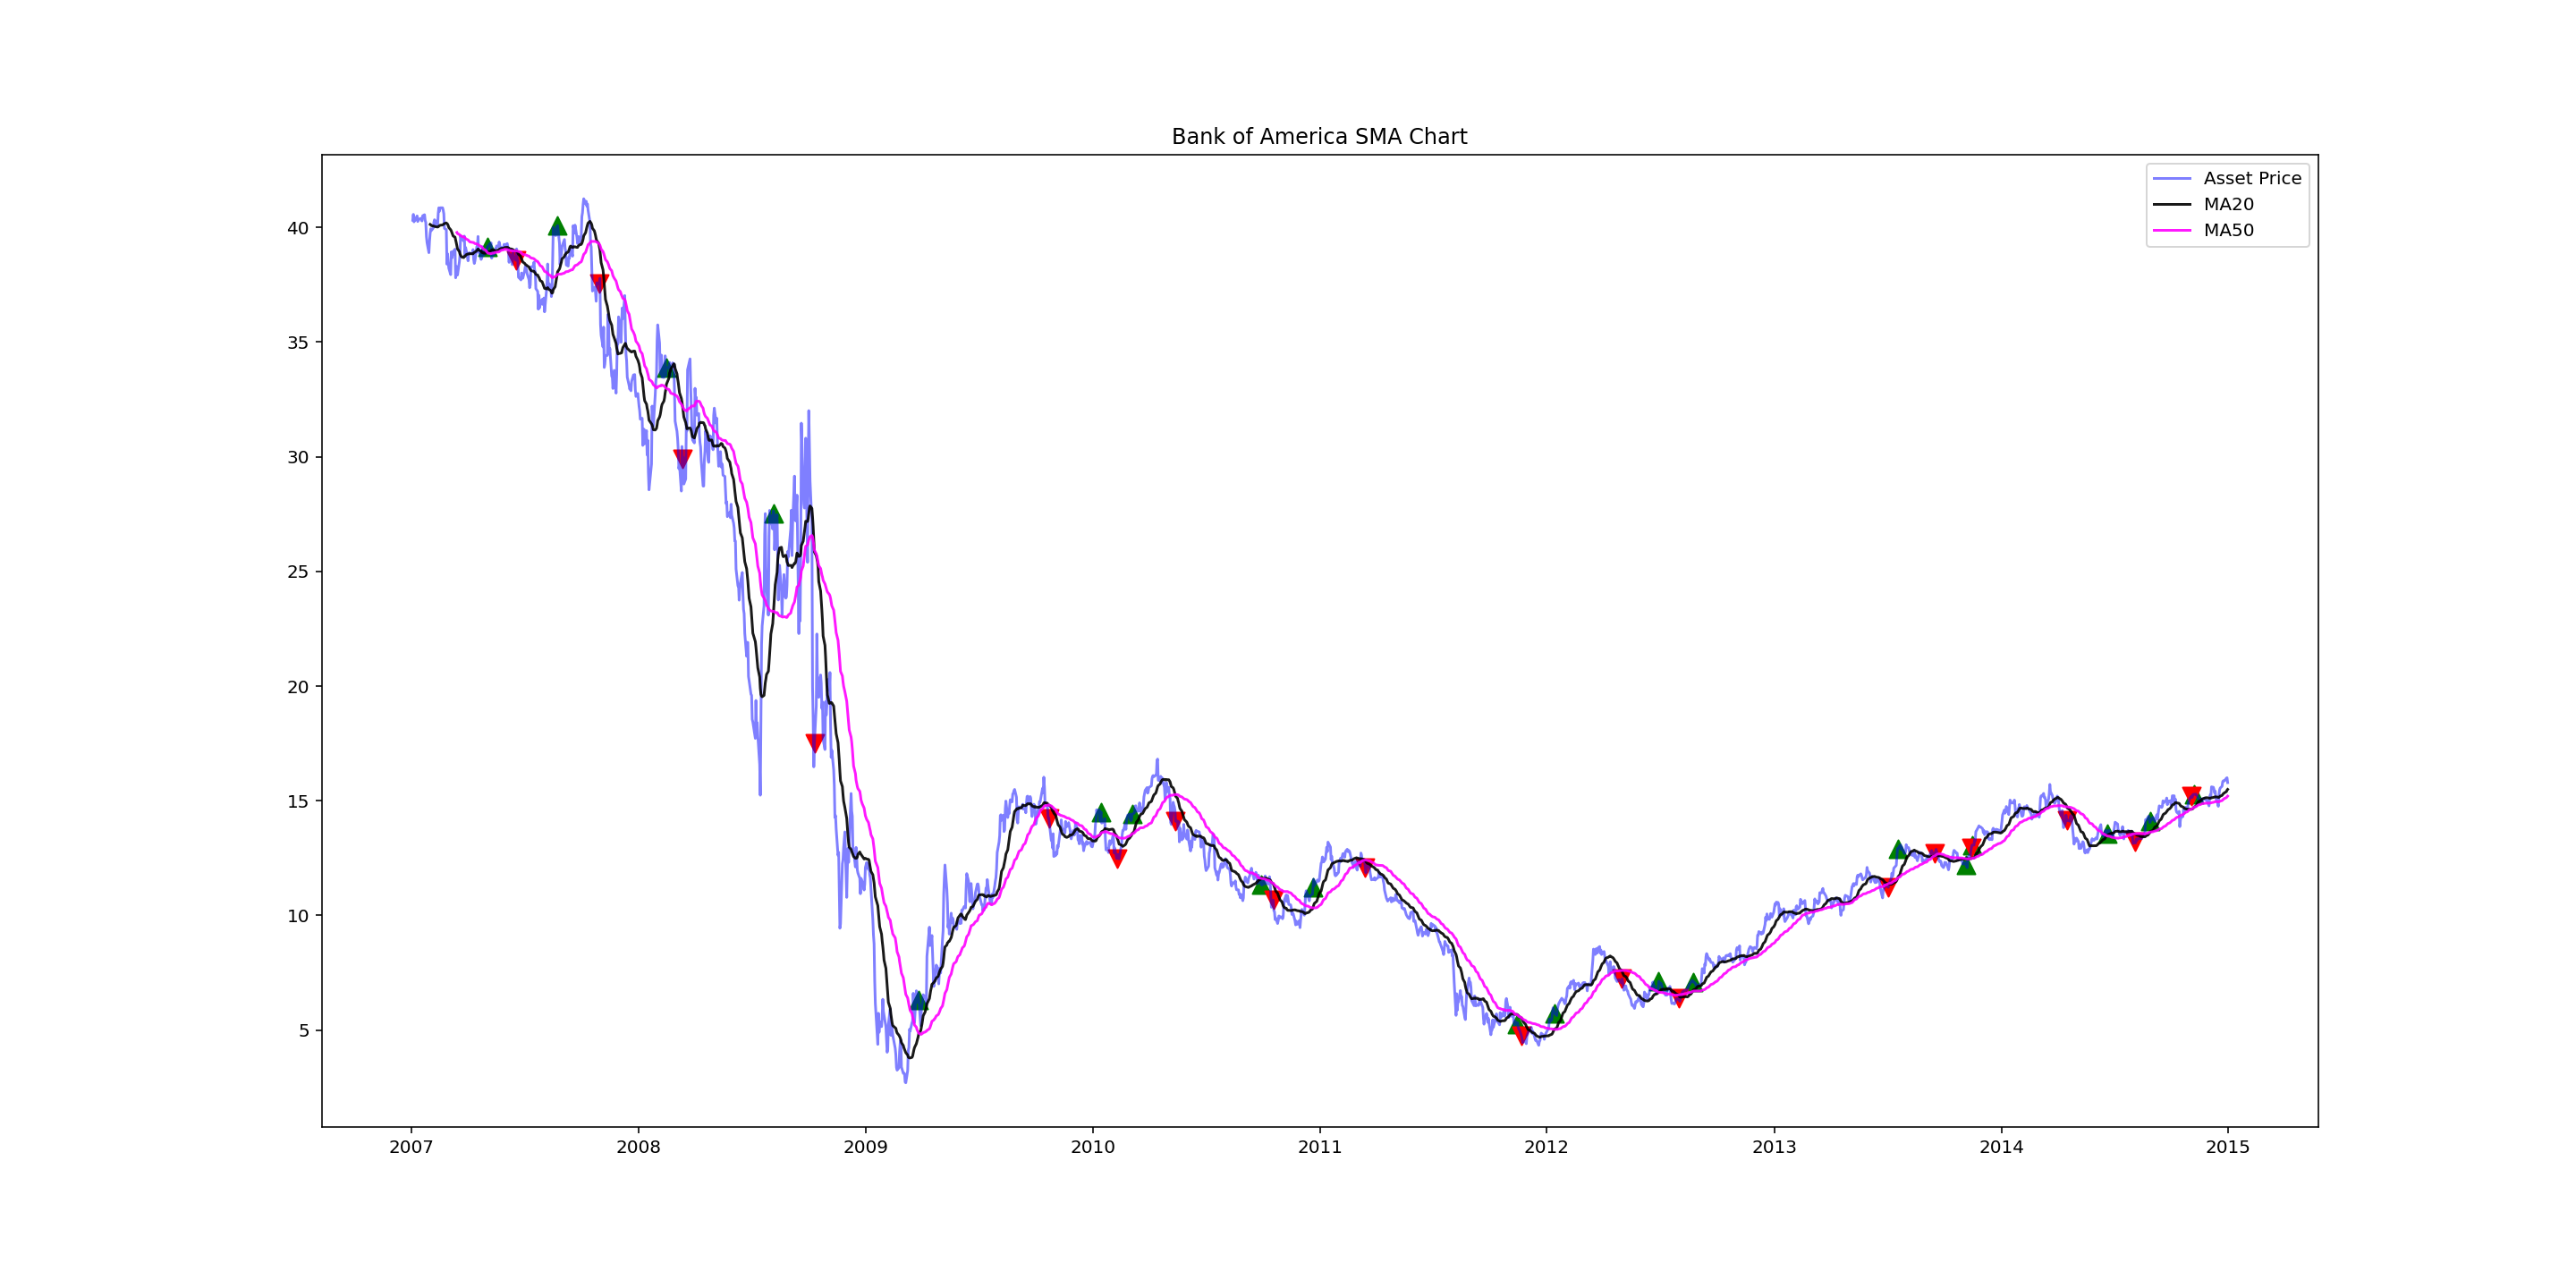
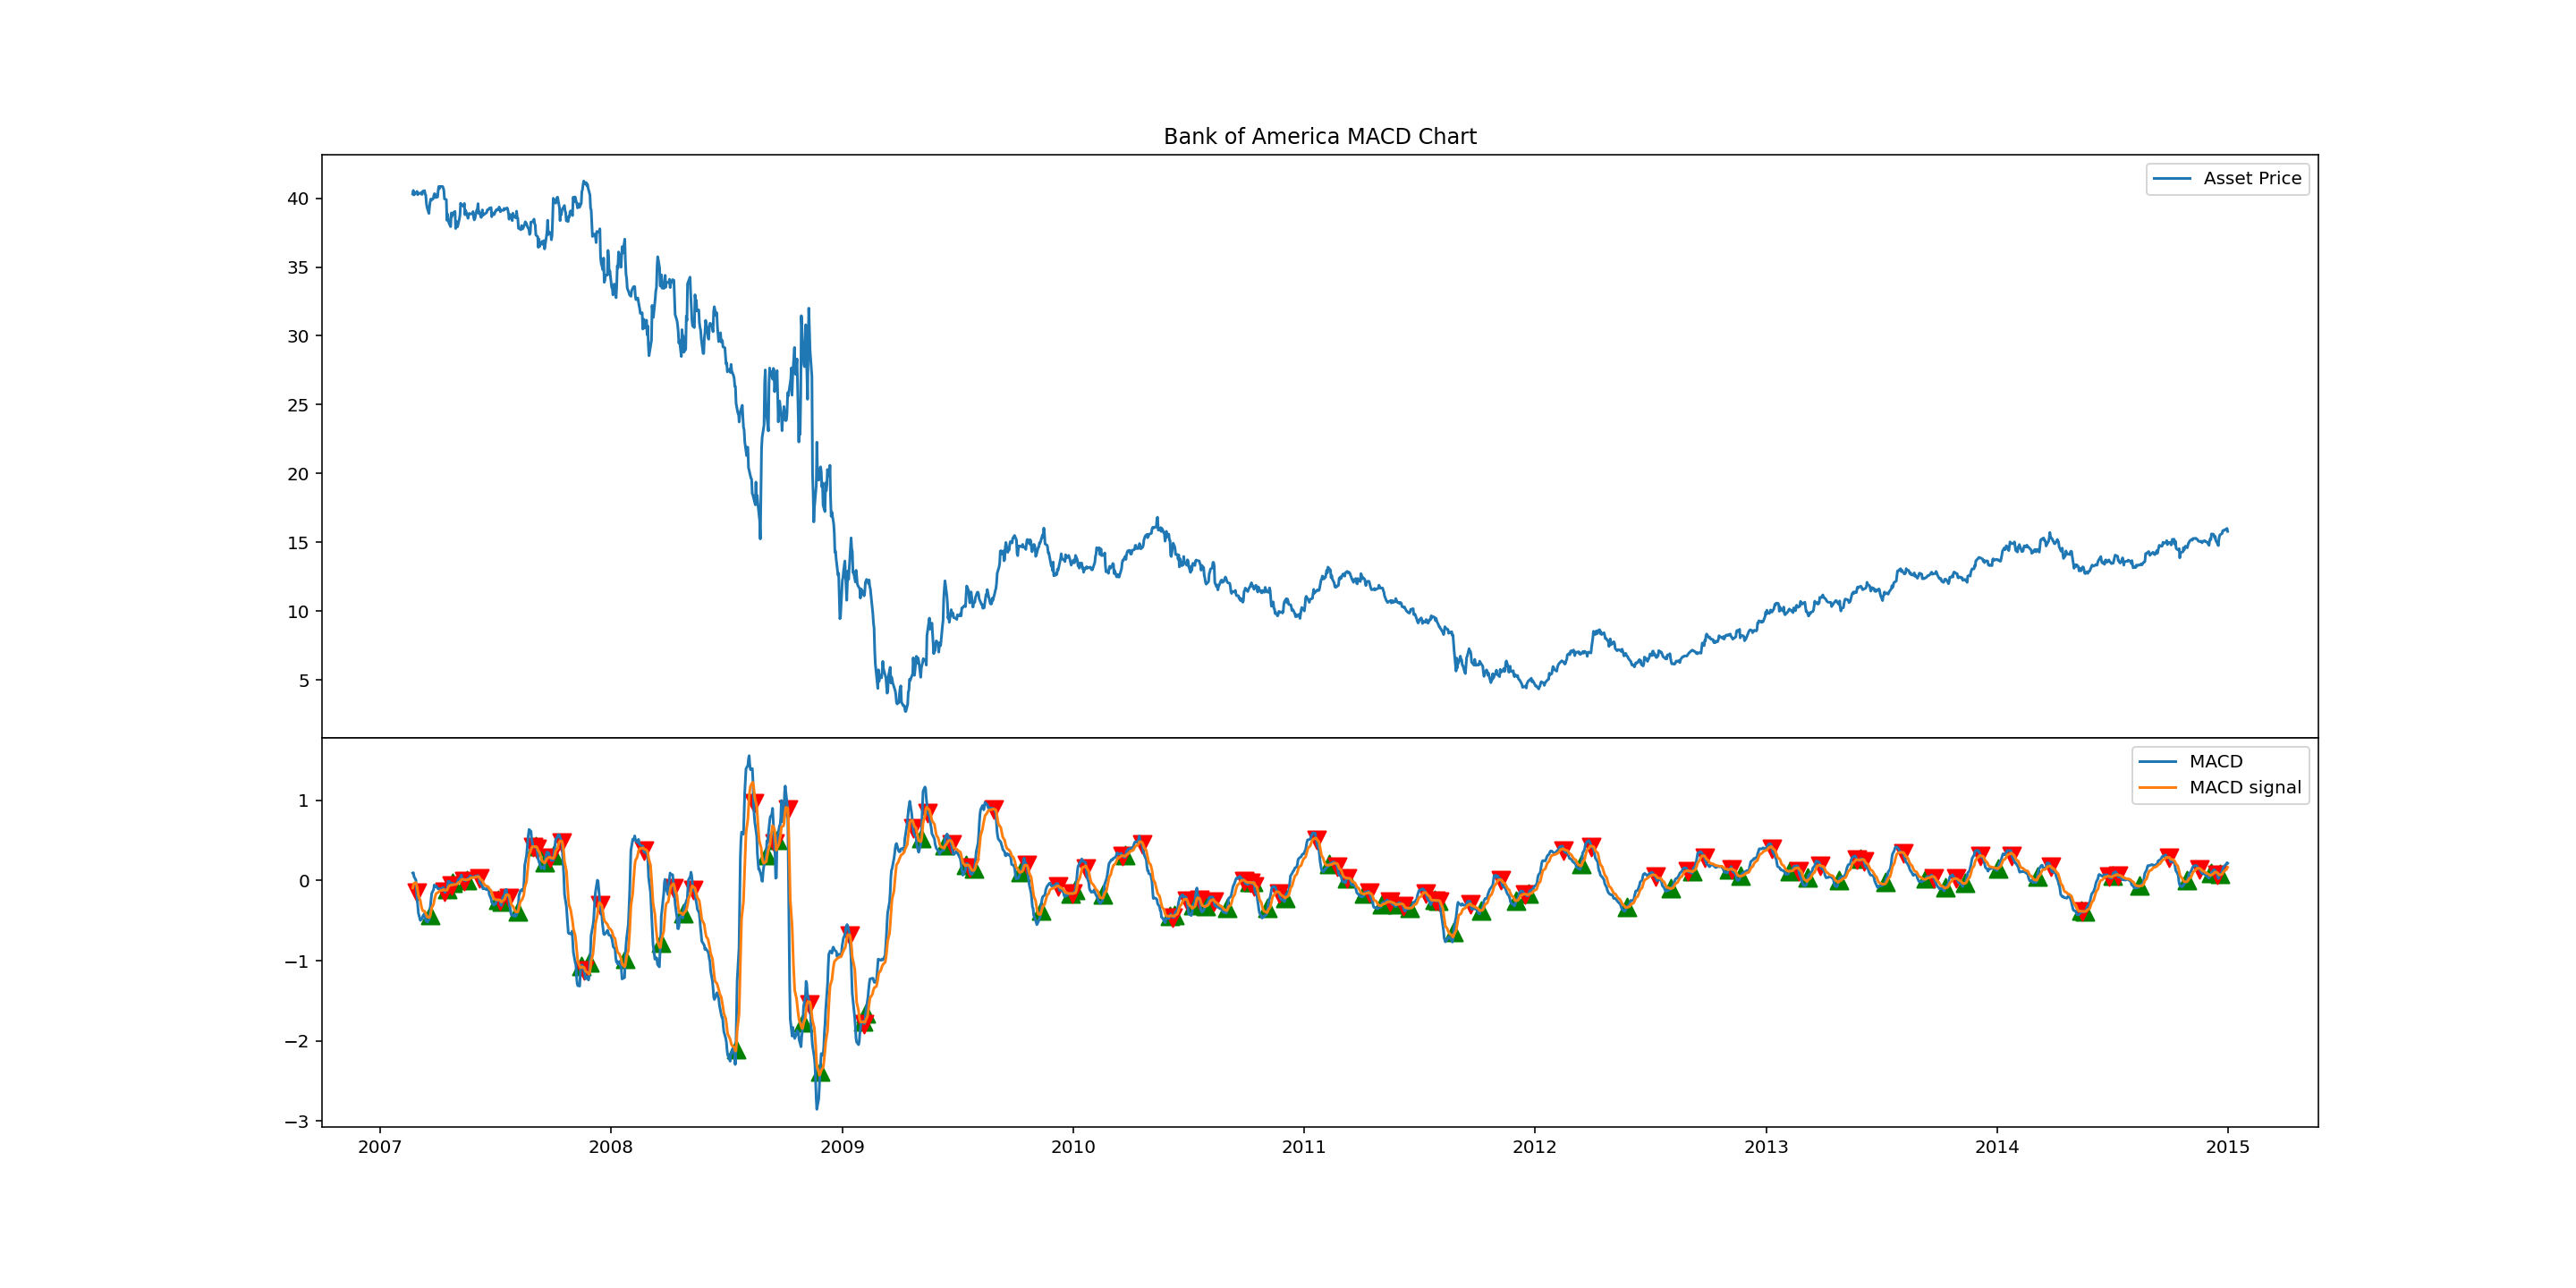
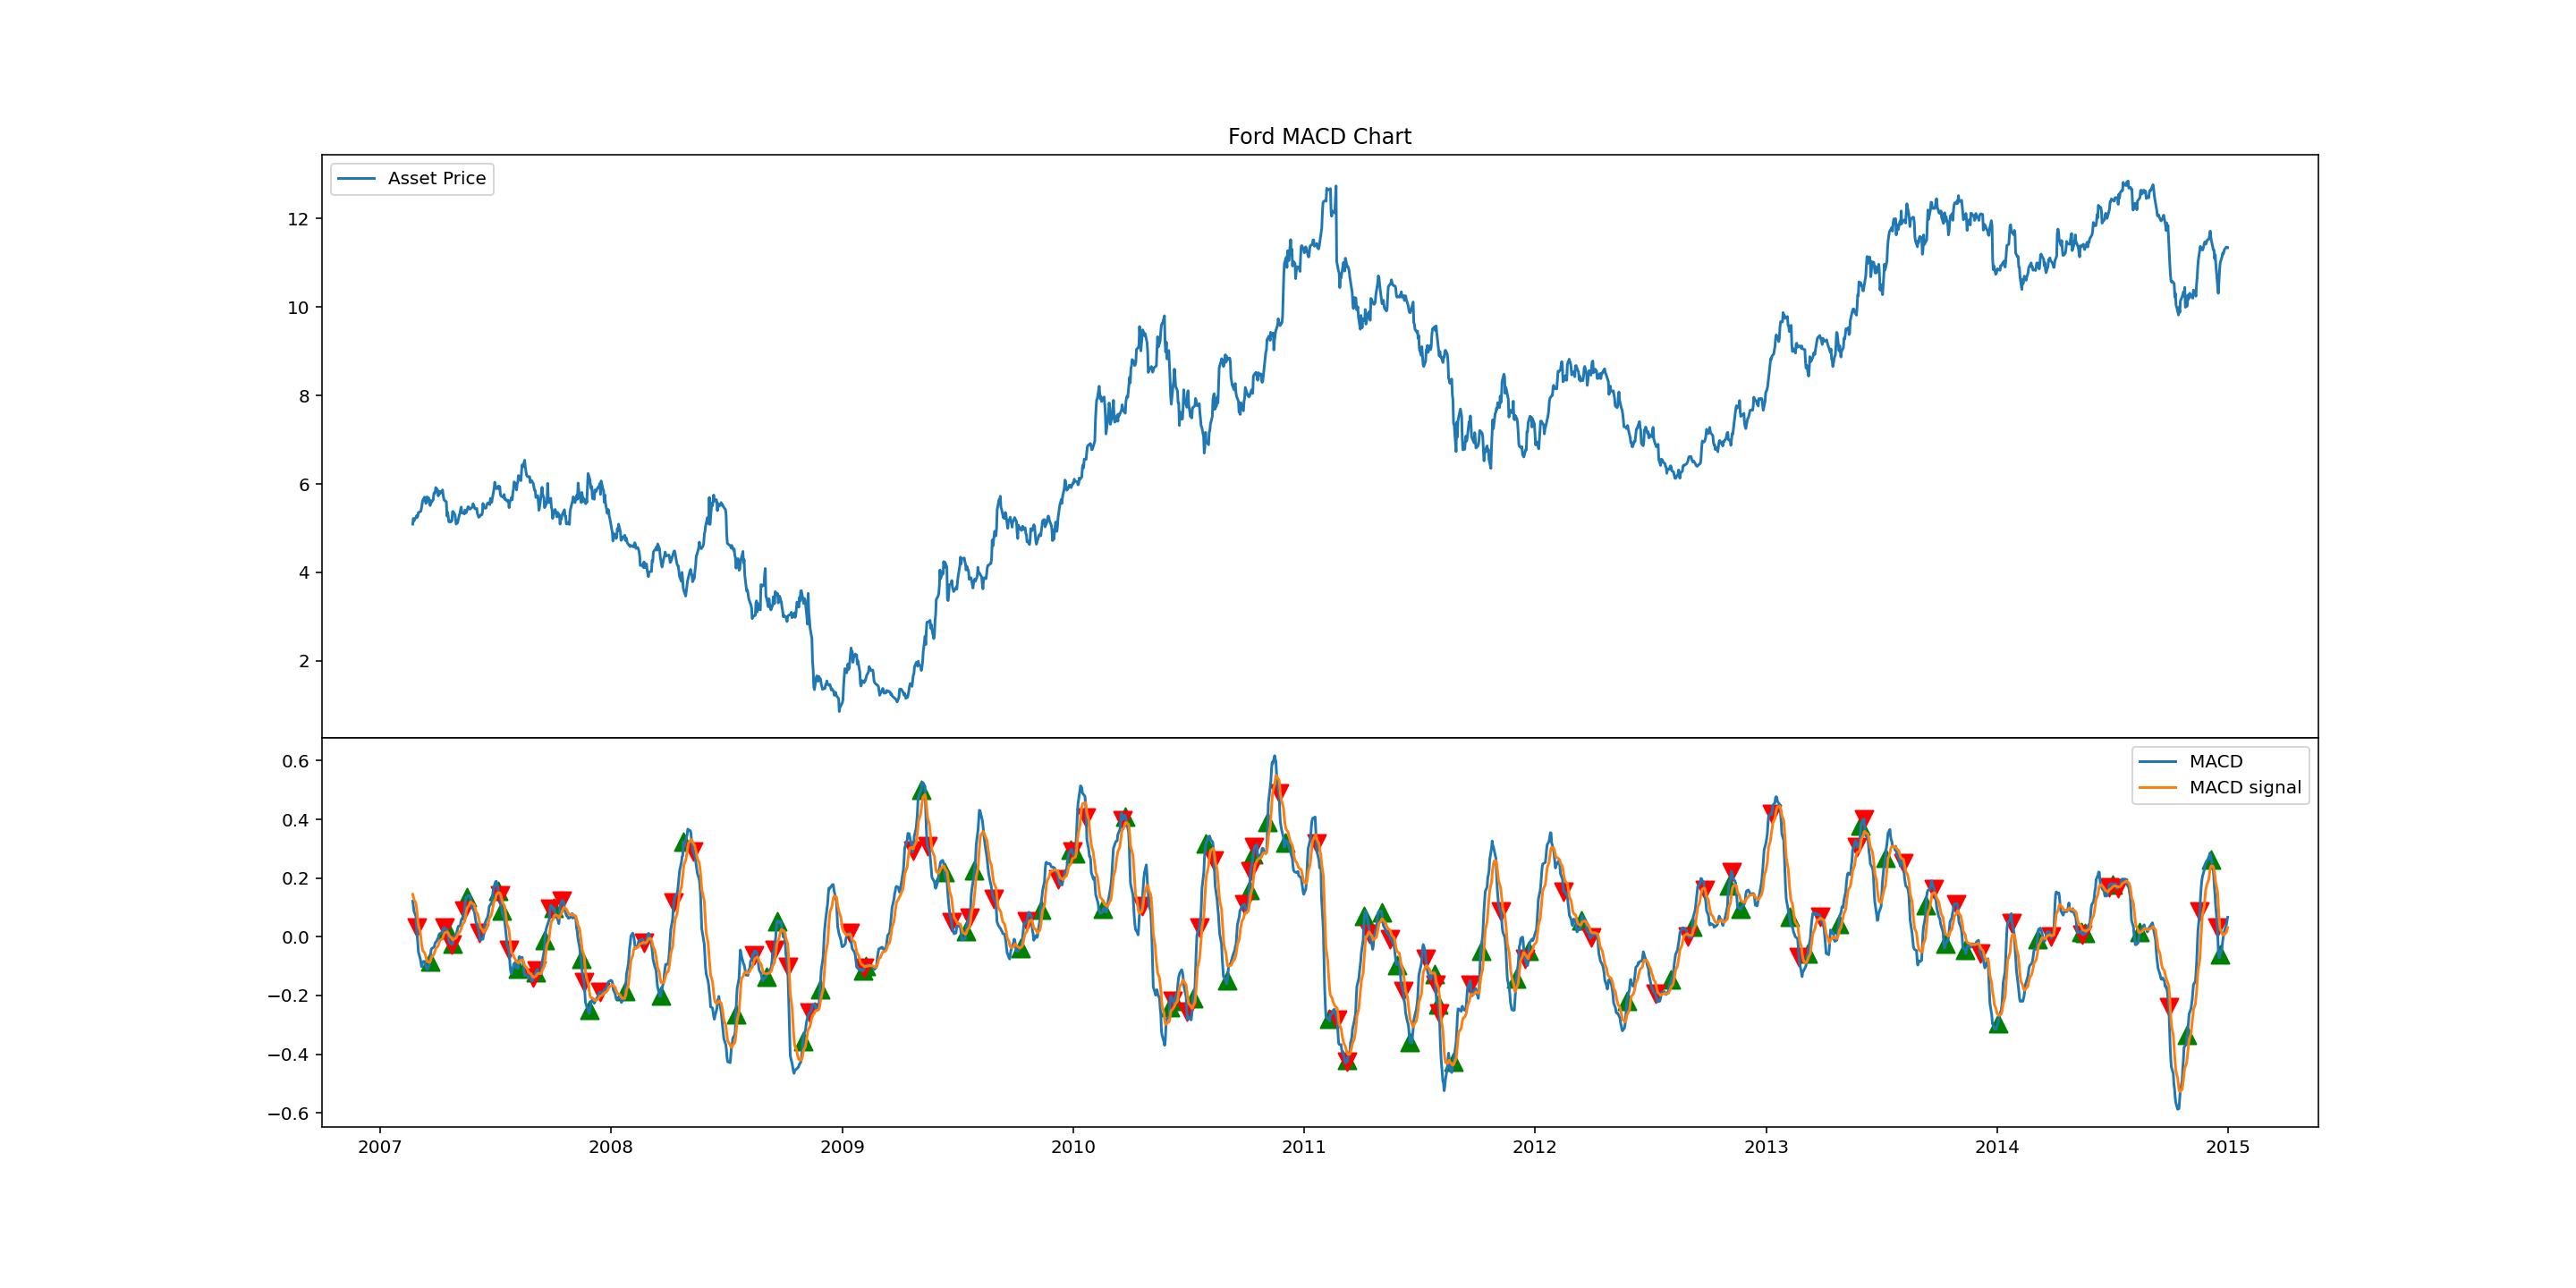
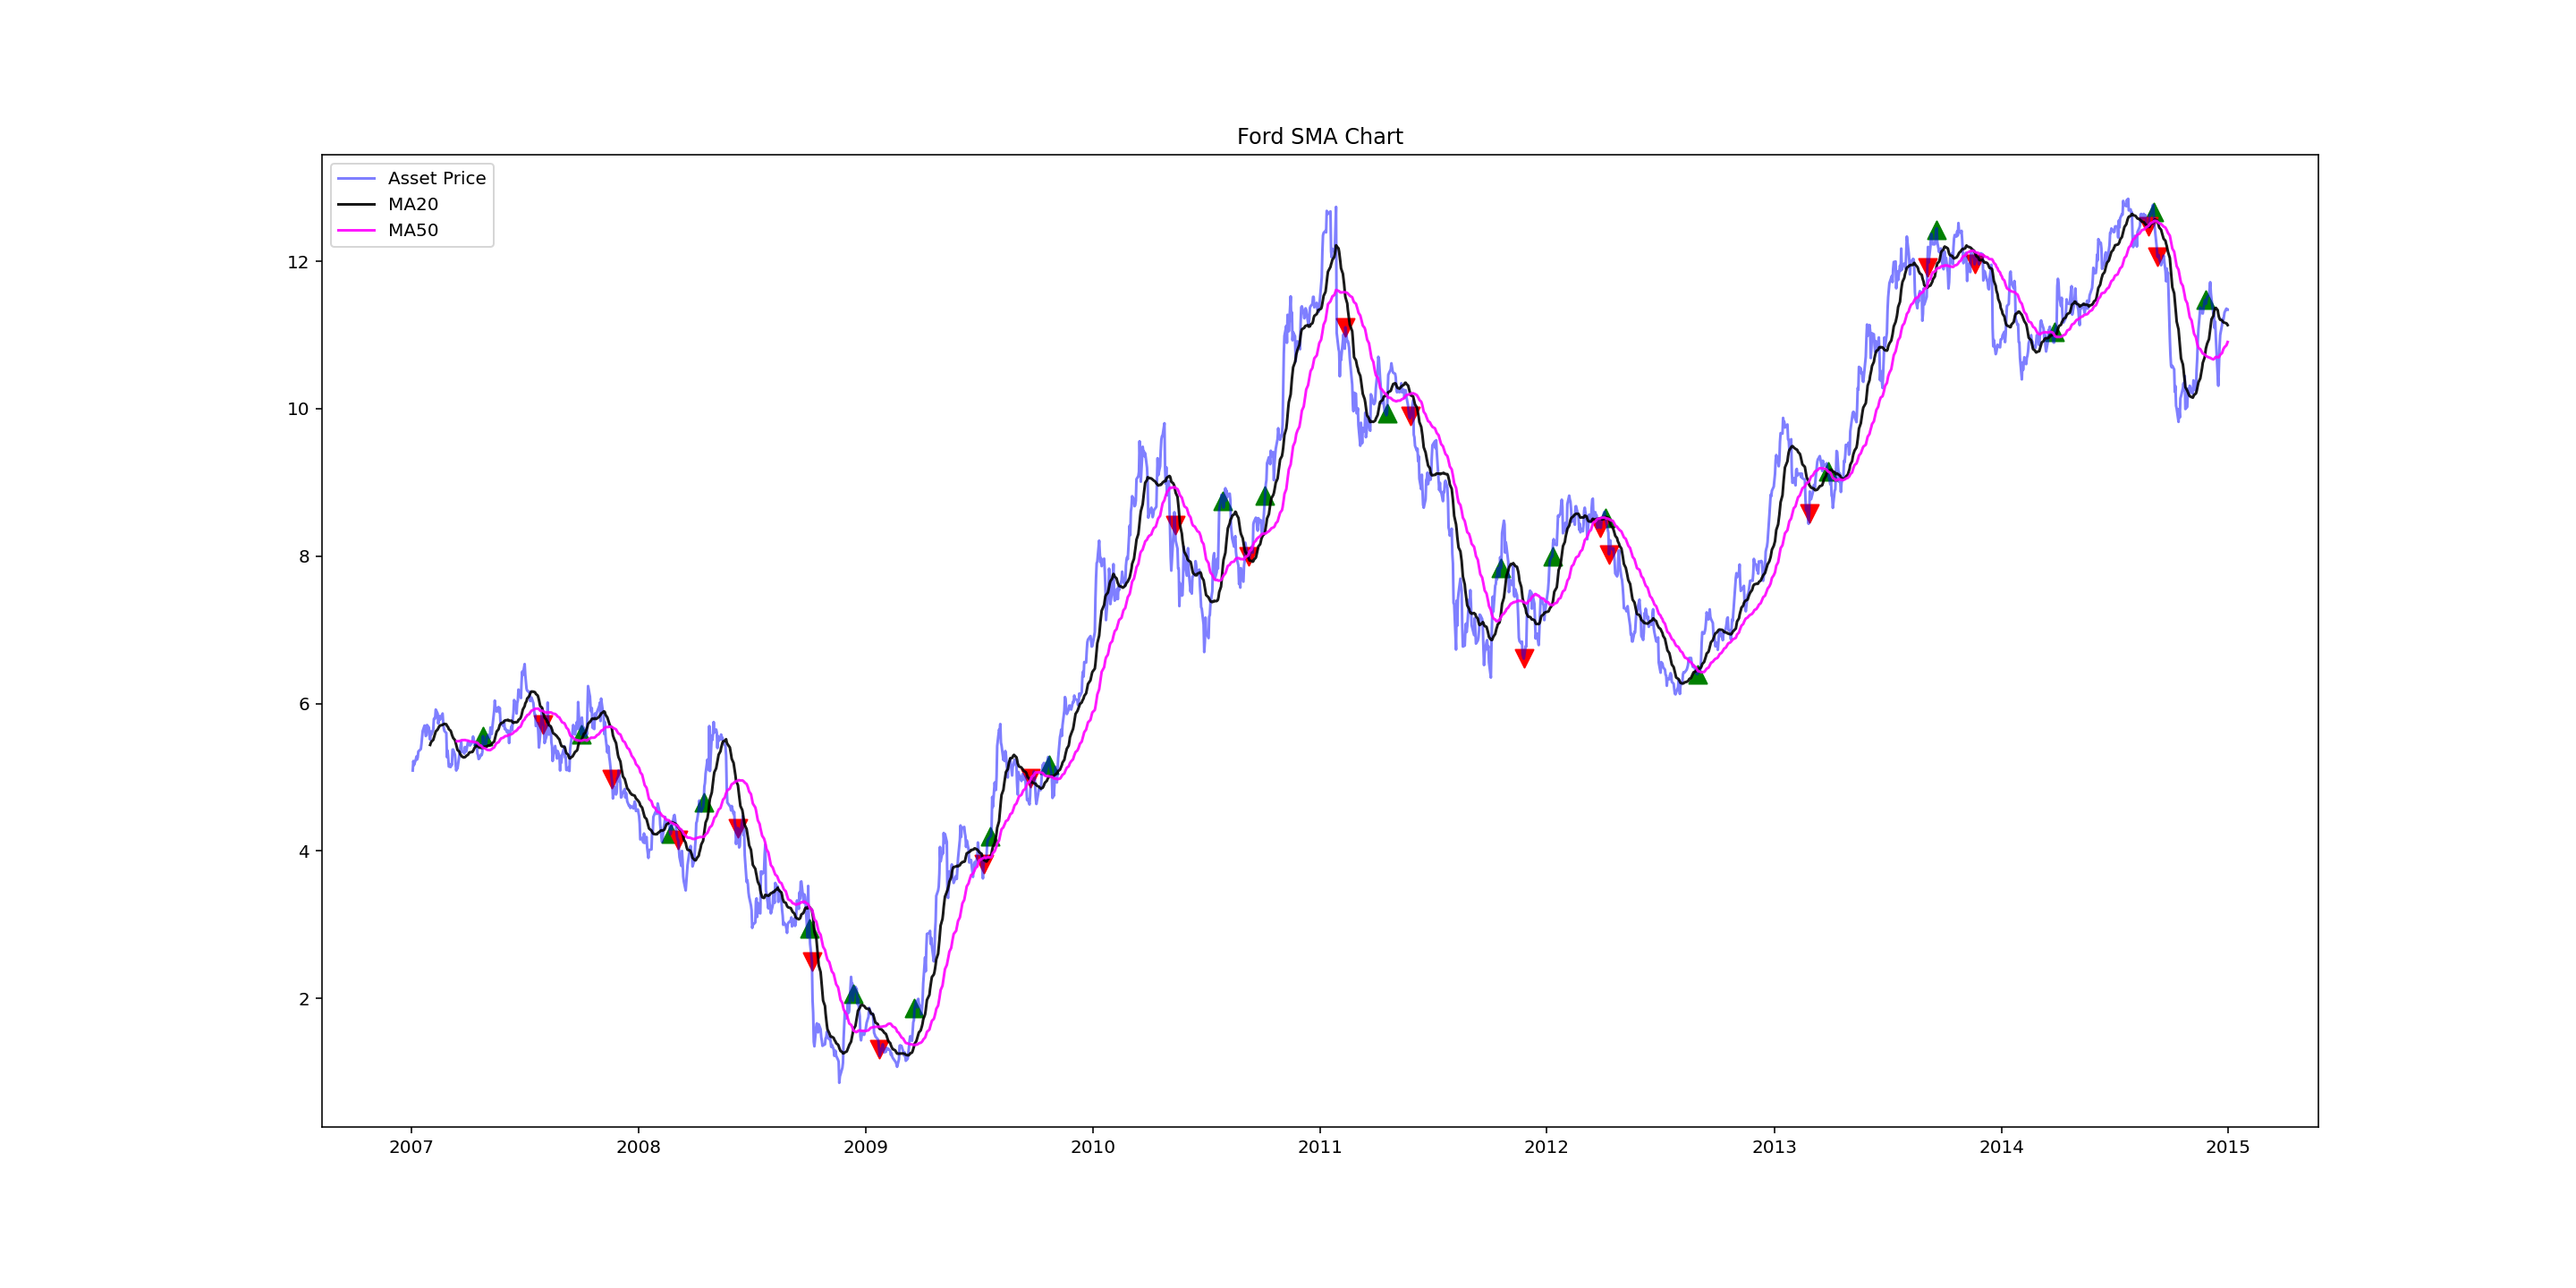
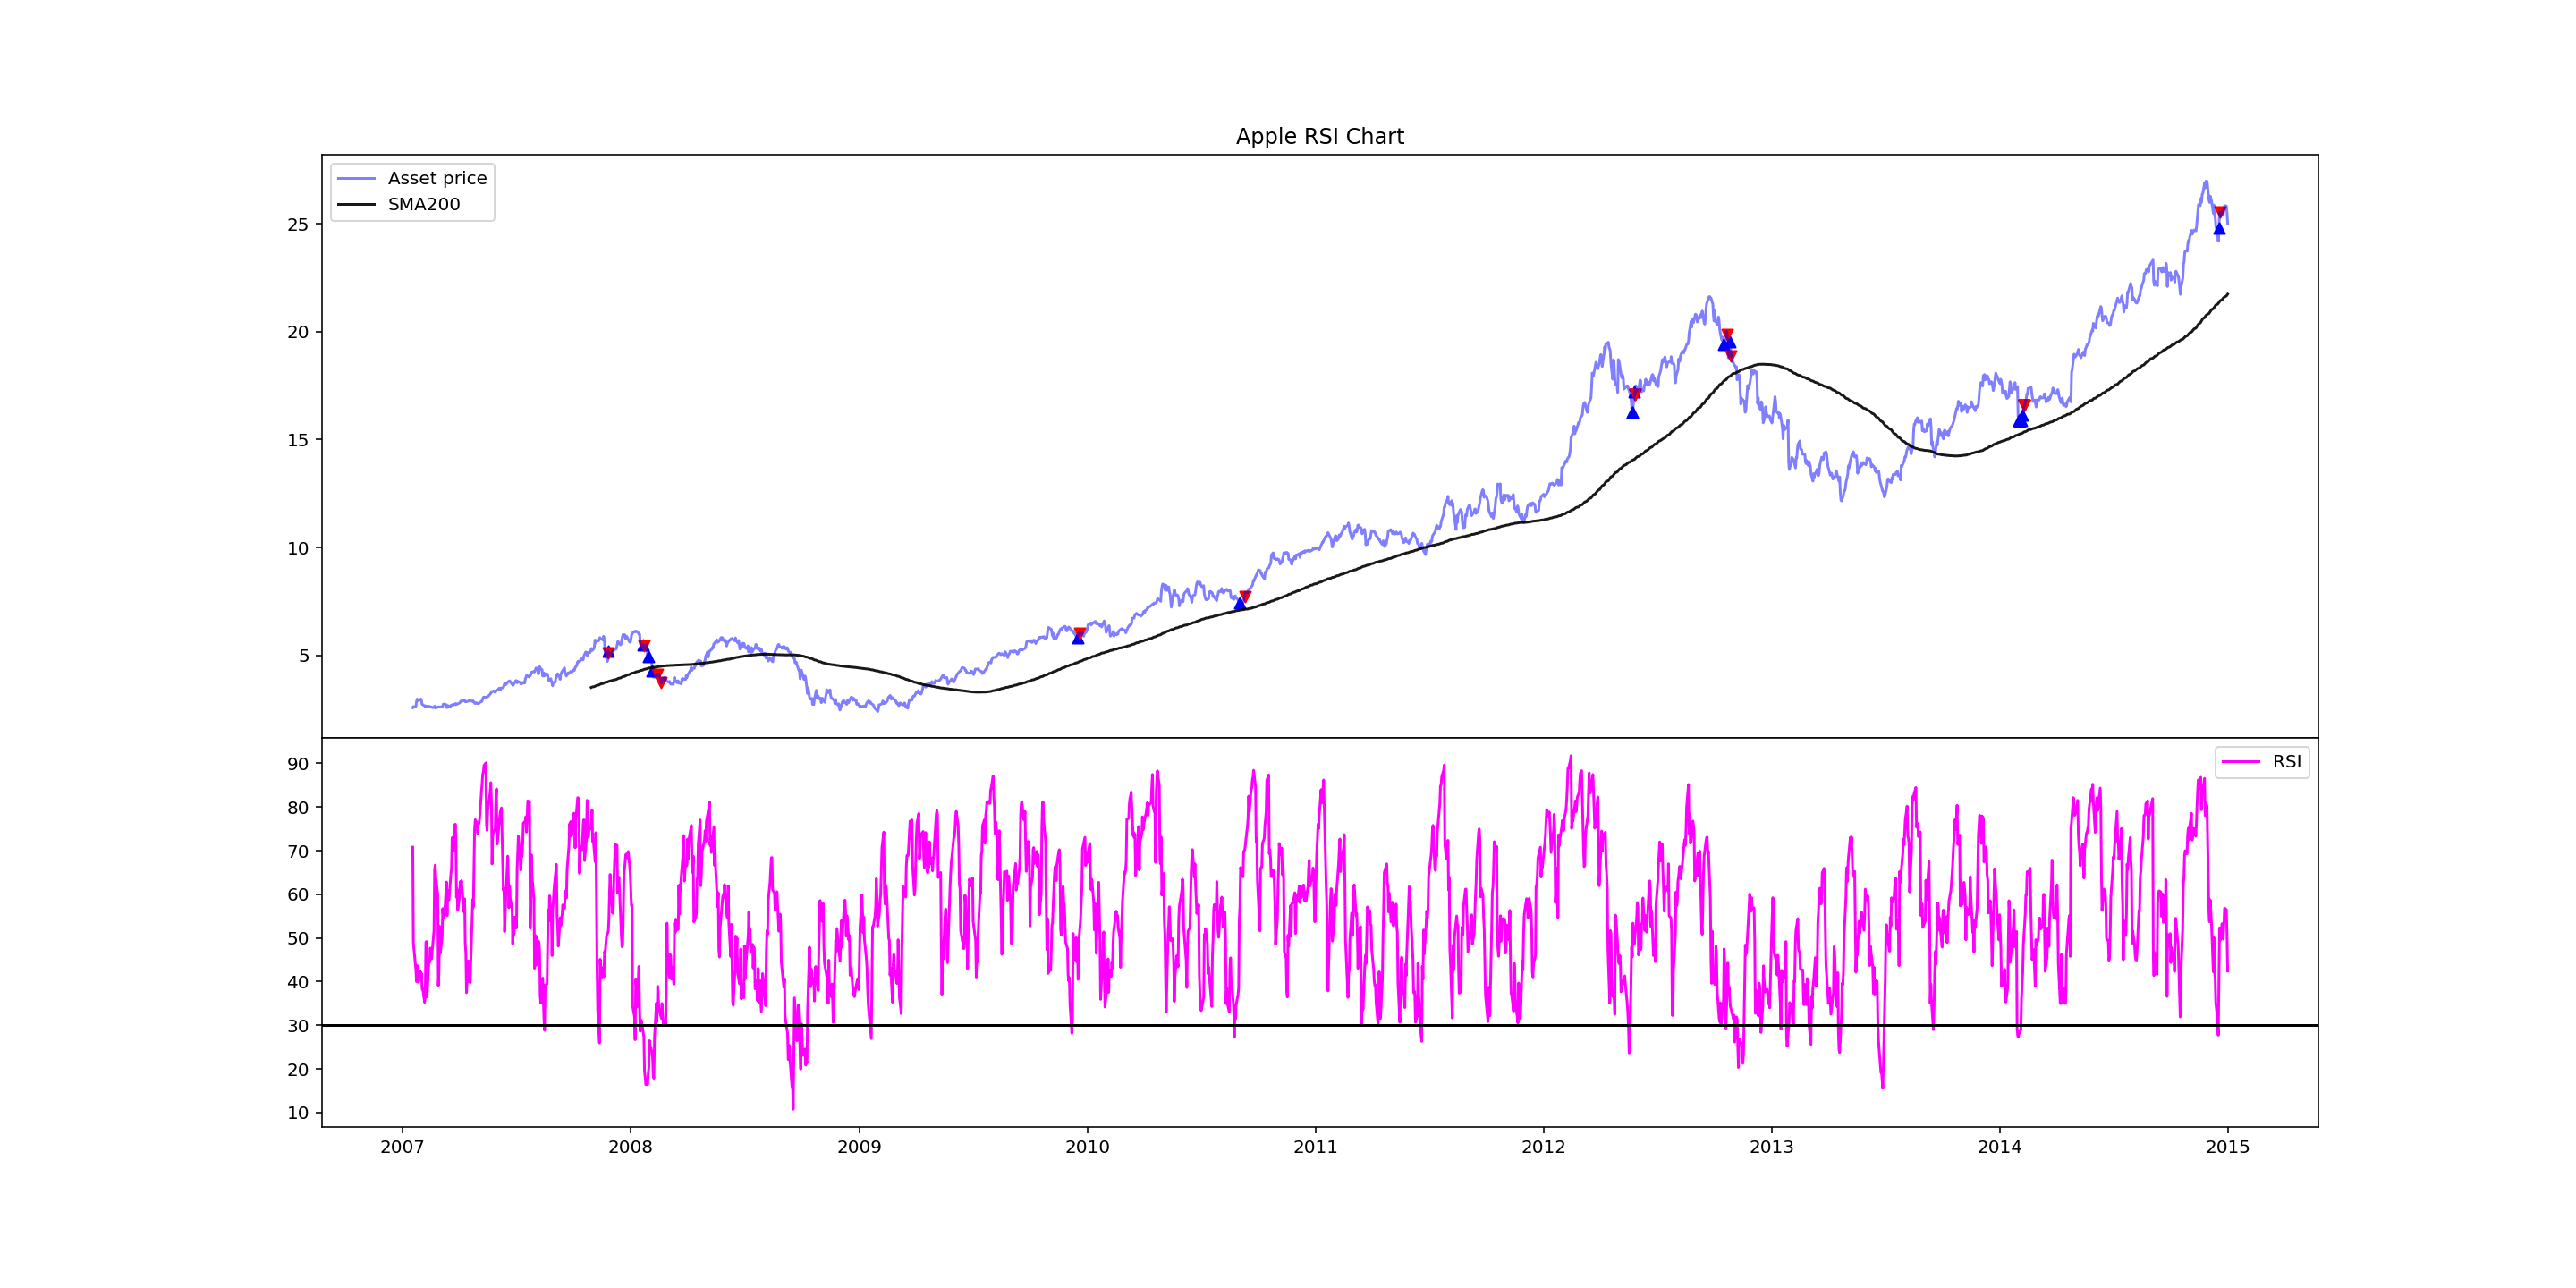
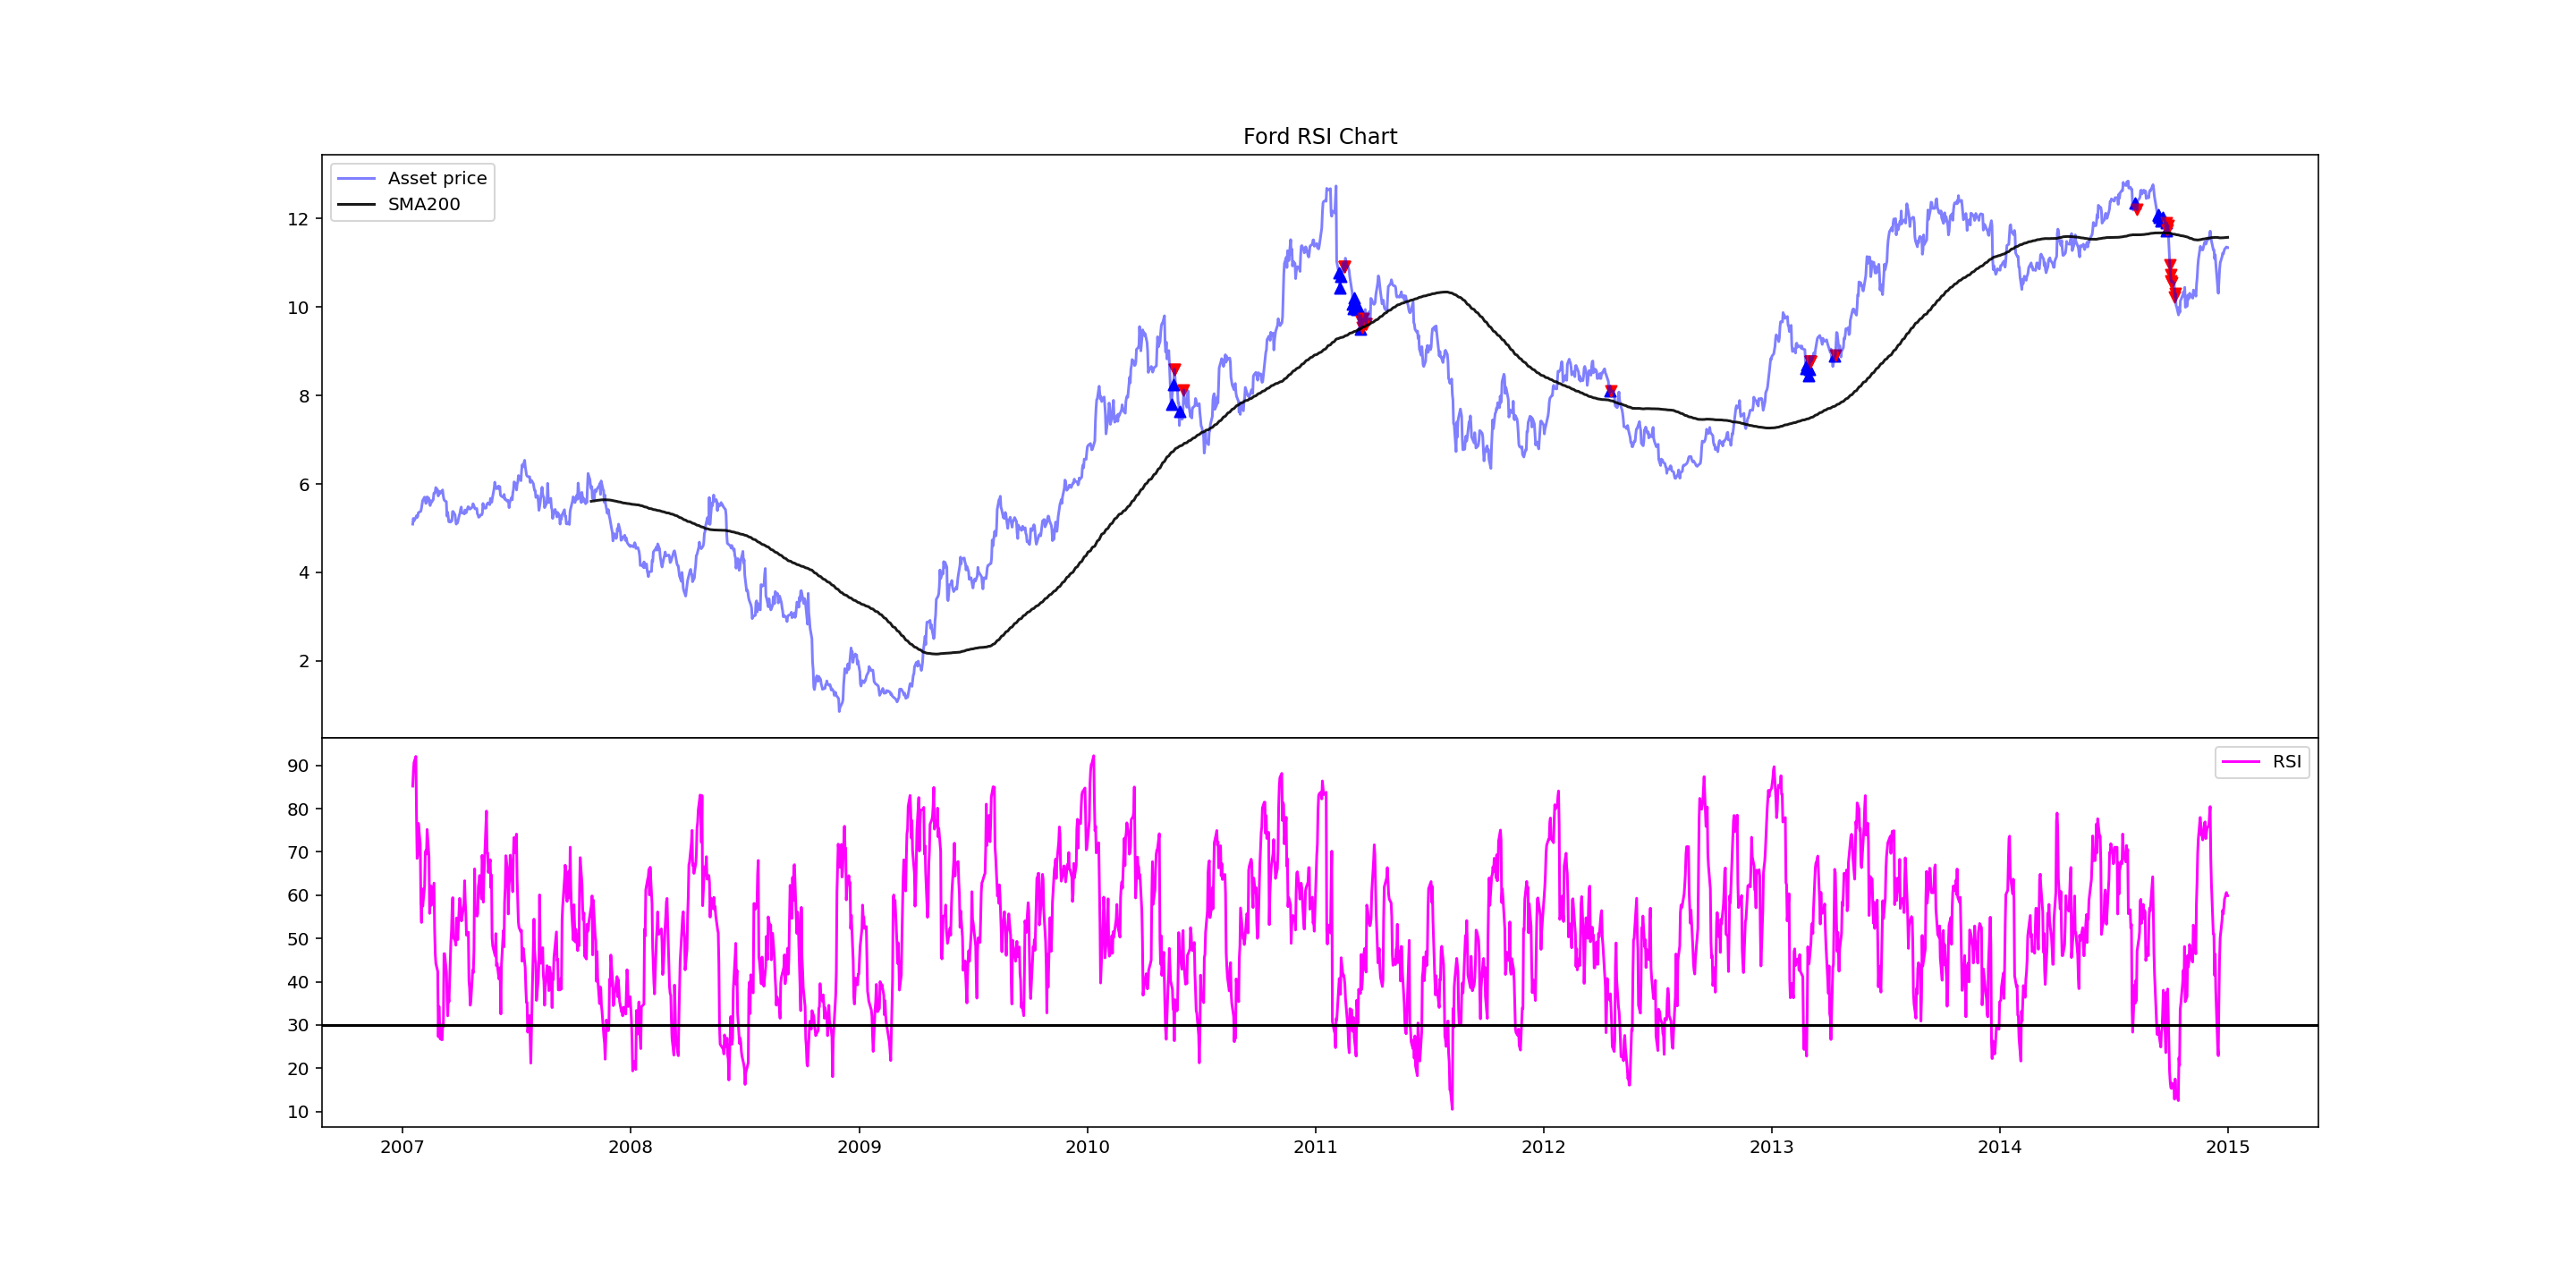
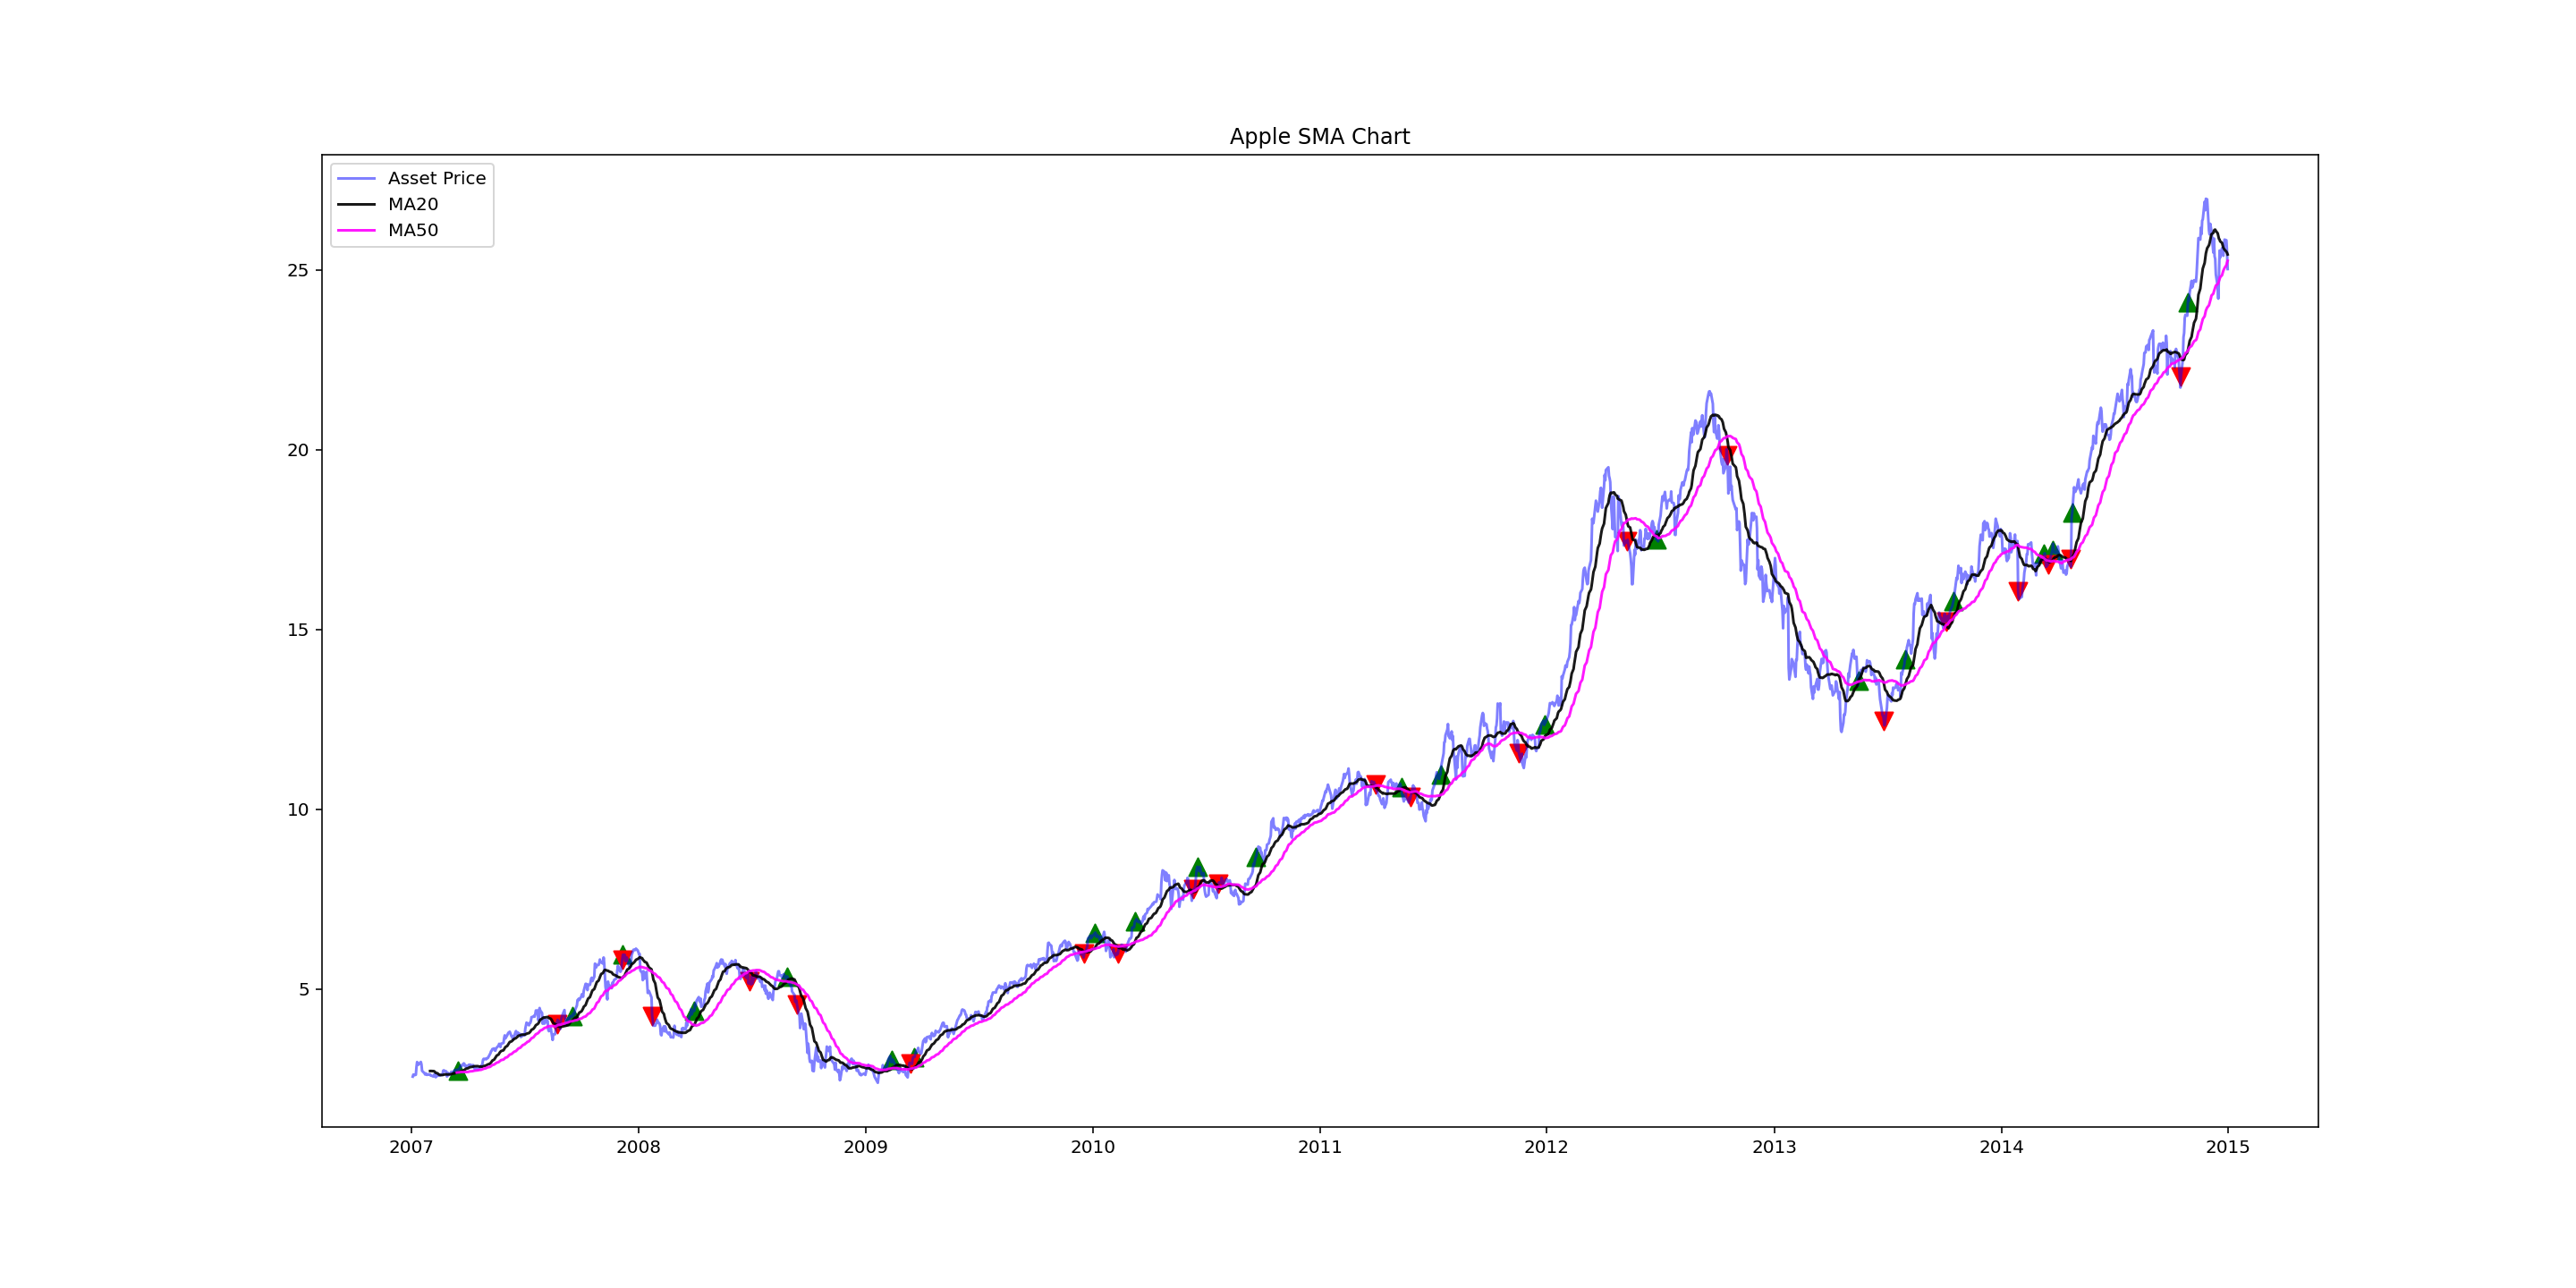
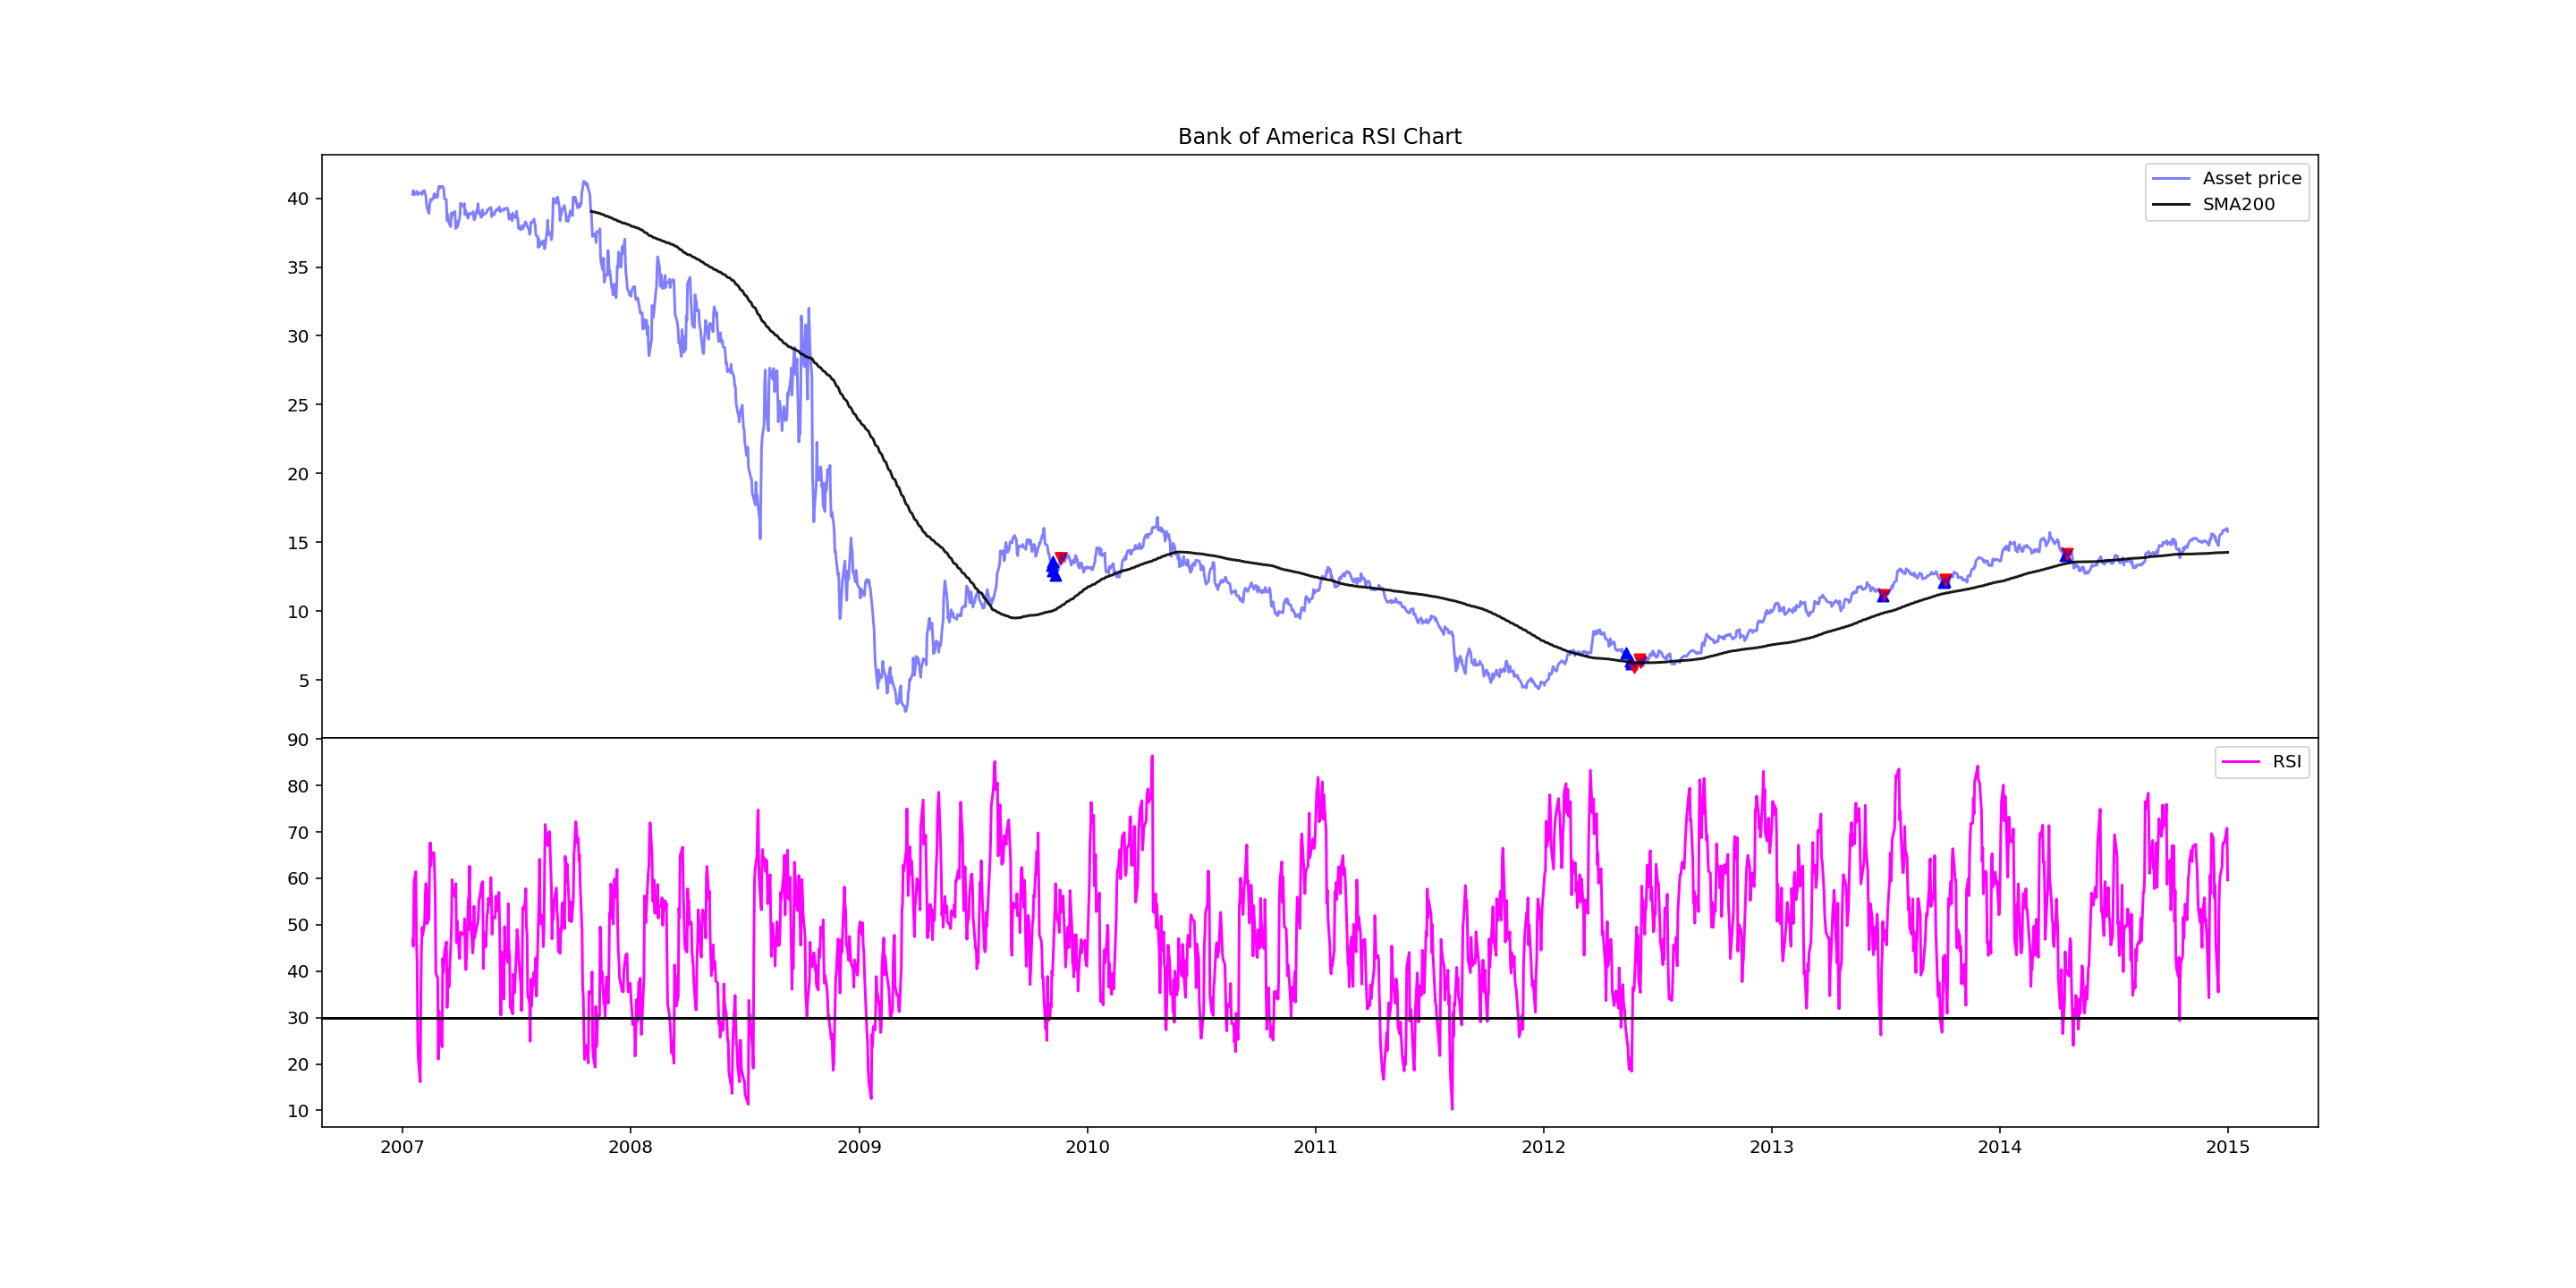

In [12]:
dashboard.servable()